<a href="https://colab.research.google.com/github/mirwisek/frame-selection-activenerf/blob/main/tiny_nerf_pytorch_rishika.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **For Rishika**

## Tiny NeRF (A PyTorch implementation)

So, this weekend, I was catching up on this _cool paper_ titled [*NeRF: Representing scenes as neural radiance fields for view synthesis*](https://arxiv.org/abs/2003.08934)!

The authors released a TensorFlow implementation [here](https://github.com/bmild/nerf). Deciding to delve deeper, I ported their code to PyTorch, cause why not!

> *DISCLAIMER*: This notebook (and repository) is work-in-progress. Although I have rigorously tested most modules in here (to faithfully replicate the original implementation), my implementation at places deviates from the authors'. Comments/criticism welcome!

> All functions that have a `#TESTED` under the docstring imply that they have been tested against their corresponding tensorflow impls.

In [1]:
!pip3 install umap-learn
!pip3 install hdbscan
!pip3 install lpips
!pip3 install torchmetrics

In [2]:
# Import all the good stuff
from typing import Optional

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
from sklearn.decomposition import PCA
import umap
from umap import umap_ as UMAP
import lpips
import seaborn as sns

from hdbscan import HDBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from skimage.metrics import structural_similarity as SSIM
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity as LPIPS
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

## A few utility functions

#### Bridging PyTorch and TensorFlow functionality

There's plenty of differences in function signatures (and in functionality) b/w PyTorch and TensorFlow. Here's a few modules that help bridge the gap (for this particular impl).

In [3]:
def meshgrid_xy(tensor1: torch.Tensor, tensor2: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    # TESTED
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)


def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
  r"""Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

  Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
      is to be computed.

  Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
      tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
  """
  # TESTED
  # Only works for the last dimension (dim=-1)
  dim = -1
  # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
  cumprod = torch.cumprod(tensor, dim)
  # "Roll" the elements along dimension 'dim' by 1 element.
  cumprod = torch.roll(cumprod, 1, dim)
  # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
  cumprod[..., 0] = 1.

  return cumprod

#### Compute the "bundle" of rays through all pixels of an image.

In [4]:
def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
  r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

  Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.

  Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
  """
  # TESTED
  ii, jj = meshgrid_xy(
      torch.arange(width).to(tform_cam2world),
      torch.arange(height).to(tform_cam2world)
  )
  directions = torch.stack([(ii - width * .5) / focal_length,
                            -(jj - height * .5) / focal_length,
                            -torch.ones_like(ii)
                           ], dim=-1)
  ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)
  ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
  return ray_origins, ray_directions

#### Compute "query" 3D points given the "bundle" of rays.

We assume that a _near_ and a _far_ clipping distance are provided that delineate the volume of interest. Each ray is evaluated only within these bounds. We randomly sample points along each ray, while trying to ensure most parts of the ray's trajectory are spanned.

In [5]:
def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize: Optional[bool] = True
) -> (torch.Tensor, torch.Tensor):
  r"""Compute query 3D points given the "bundle" of rays. The near_thresh and far_thresh
  variables indicate the bounds within which 3D points are to be sampled.

  Args:
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    ray_directions (torch.Tensor): Direction of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    near_thresh (float): The 'near' extent of the bounding volume (i.e., the nearest depth
      coordinate that is of interest/relevance).
    far_thresh (float): The 'far' extent of the bounding volume (i.e., the farthest depth
      coordinate that is of interest/relevance).
    num_samples (int): Number of samples to be drawn along each ray. Samples are drawn
      randomly, whilst trying to ensure "some form of" uniform spacing among them.
    randomize (optional, bool): Whether or not to randomize the sampling of query points.
      By default, this is set to `True`. If disabled (by setting to `False`), we sample
      uniformly spaced points along each ray in the "bundle".

  Returns:
    query_points (torch.Tensor): Query points along each ray
      (shape: :math:`(width, height, num_samples, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).
  """
  # TESTED
  # shape: (num_samples)
  depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
  if randomize is True:
    # ray_origins: (width, height, 3)
    # noise_shape = (width, height, num_samples)
    noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
    # depth_values: (num_samples)
    depth_values = depth_values \
        + torch.rand(noise_shape).to(ray_origins) * (far_thresh
            - near_thresh) / num_samples
  # (width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
  # query_points:  (width, height, num_samples, 3)
  query_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_values[..., :, None]
  # TODO: Double-check that `depth_values` returned is of shape `(num_samples)`.
  return query_points, depth_values

#### Volumetric rendering

> **NOTE**: This volumetric rendering module (like the authors' tiny_nerf [Colab notebook](https://colab.research.google.com/github/bmild/nerf/blob/master/tiny_nerf.ipynb) does not implement 5D input (which includes view directions, in addition to X, Y, Z coordinates). It also does not implement the hierarchical sampling procedure. For those implementations, refer to the other complete examples in the repo.

In [6]:
def render_volume_density(
    radiance_field: torch.Tensor,
    ray_origins: torch.Tensor,
    depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
  r"""Differentiably renders a radiance field, given the origin of each ray in the
  "bundle", and the sampled depth values along them.

  Args:
    radiance_field (torch.Tensor): A "field" where, at each query location (X, Y, Z),
      we have an emitted (RGB) color and a volume density (denoted :math:`\sigma` in
      the paper) (shape: :math:`(width, height, num_samples, 4)`).
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).

  Returns:
    rgb_map (torch.Tensor): Rendered RGB image (shape: :math:`(width, height, 3)`).
    depth_map (torch.Tensor): Rendered depth image (shape: :math:`(width, height)`).
    acc_map (torch.Tensor): # TODO: Double-check (I think this is the accumulated
      transmittance map).
  """
  # TESTED
  sigma_a = torch.nn.functional.relu(radiance_field[..., 3])
  rgb = torch.sigmoid(radiance_field[..., :3])
  one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
  dists = torch.cat((depth_values[..., 1:] - depth_values[..., :-1],
                  one_e_10.expand(depth_values[..., :1].shape)), dim=-1)
  alpha = 1. - torch.exp(-sigma_a * dists)
  weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

  rgb_map = (weights[..., None] * rgb).sum(dim=-2)
  depth_map = (weights * depth_values).sum(dim=-1)
  acc_map = weights.sum(-1)

  return rgb_map, depth_map, acc_map

#### Positional encoding

Another interesting tweak used in NeRF is "positional encoding", which postulates the use of a mapping to higher dimensional space (using a basis set of high-frequency functions). This greatly enhances the model's capability to capture high-frequency variations.

In [7]:
def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:
  r"""Apply positional encoding to the input.

  Args:
    tensor (torch.Tensor): Input tensor to be positionally encoded.
    num_encoding_functions (optional, int): Number of encoding functions used to
        compute a positional encoding (default: 6).
    include_input (optional, bool): Whether or not to include the input in the
        computed positional encoding (default: True).
    log_sampling (optional, bool): Sample logarithmically in frequency space, as
        opposed to linearly (default: True).

  Returns:
    (torch.Tensor): Positional encoding of the input tensor.
  """
  # TESTED
  # Trivially, the input tensor is added to the positional encoding.
  encoding = [tensor] if include_input else []
  # Now, encode the input using a set of high-frequency functions and append the
  # resulting values to the encoding.
  frequency_bands = None
  if log_sampling:
      frequency_bands = 2.0 ** torch.linspace(
            0.0,
            num_encoding_functions - 1,
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )
  else:
      frequency_bands = torch.linspace(
          2.0 ** 0.0,
          2.0 ** (num_encoding_functions - 1),
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
      )

  for freq in frequency_bands:
      for func in [torch.sin, torch.cos]:
          encoding.append(func(tensor * freq))

  # Special case, for no positional encoding
  if len(encoding) == 1:
      return encoding[0]
  else:
      return torch.cat(encoding, dim=-1)

## TinyNeRF: Network architecture

In [8]:
class VeryTinyNerfModel(torch.nn.Module):
  r"""Define a "very tiny" NeRF model comprising three fully connected layers.
  """
  def __init__(self, filter_size=128, num_encoding_functions=6):
    super(VeryTinyNerfModel, self).__init__()
    # Input layer (default: 39 -> 128)
    self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
    # Layer 2 (default: 128 -> 128)
    self.layer2 = torch.nn.Linear(filter_size, filter_size)
    # Layer 3 (default: 128 -> 4)
    self.layer3 = torch.nn.Linear(filter_size, 4)
    # Short hand for torch.nn.functional.relu
    self.relu = torch.nn.functional.relu

  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.layer3(x)
    return x

## Dataloading utils

In [9]:
def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
  r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
  Each element of the list (except possibly the last) has dimension `0` of length
  `chunksize`.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

## Get data

In [10]:
# Download sample data used in the official tiny_nerf example
import os
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

## Determine device to run on (GPU vs CPU)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load up input images, poses, intrinsics, etc.

In [12]:
# Load input images, poses, and intrinsics
data = np.load("tiny_nerf_data.npz")

# Images
images = data["images"]
# Camera extrinsics (poses)
tform_cam2world = data["poses"]
# Focal length (intrinsics)
focal_length = data["focal"]
focal_length = torch.from_numpy(focal_length).to(device)

# Height and width of each image
height, width = images.shape[1:3]

# Near and far clipping thresholds for depth values.
near_thresh = 2.
far_thresh = 6.

# Hold one image out (for test).
testimgs, testposes = images[100:], tform_cam2world[100:]
testimgs = torch.from_numpy(testimgs).to(device)
testposes = torch.from_numpy(testposes).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)
tform_cam2world = torch.from_numpy(tform_cam2world[:100,]).to(device)

## Dimensionality Reduction Parameter Tuning
1. PCA

In [13]:
# Image encoder
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet18(pretrained=True).to(device)
        self.resnet.eval()

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)  # Adjust the dimensions to match [channels, batch_size, height, width]
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        feats1 = self.resnet.relu(x)
        feats2 = self.resnet.layer1(self.resnet.maxpool(feats1))
        feats3 = self.resnet.layer2(feats2)
        feats4 = self.resnet.layer3(feats3)
        latents = [feats1, feats2, feats3, feats4]
        output_size = (100, 100)
        for i in range(len(latents)):
            latents[i] = F.interpolate(
                latents[i], output_size, mode="bilinear", align_corners=True
            )
        latents = torch.cat(latents, dim=1)
        return latents

# Identify optimal PCA dimension for all the images
def converge_to_pca_dimensions(embeddings_flattened, min_variance=0.75):
    # Perform PCA for dimensionality reduction
    pca = PCA()
    pca.fit(embeddings_flattened)

    # Calculate explained variance ratio and cumulative explained variance
    explained_var_ratio = pca.explained_variance_ratio_
    cum_explained_var = np.cumsum(explained_var_ratio)

    # Find the number of components that explain the specified variance
    n_components = np.argmax(cum_explained_var >= min_variance) + 1

    if n_components > 100:
      print('Max number of components reached..\n')
      n_components = 100

    # Retrain PCA with the selected number of components
    pca = PCA(n_components=n_components)
    dim_reduction = pca.fit_transform(embeddings_flattened)

    print(f'Number of components: {n_components}\n')

    return dim_reduction, pca.explained_variance_ratio_, n_components

# Instantiate the ImageEncoder
image_encoder = ImageEncoder()

# Get the embeddings for the 100 images
processed_images_tensor = torch.tensor(images).to(device)
with torch.no_grad():
    embeddings = image_encoder(processed_images_tensor)
embeddings_flattened = embeddings.cpu().numpy().reshape(embeddings.shape[0], -1)

# Calculate the optimal number of components for PCA
target_variance = 0.95  # Adjust this as needed
reduced_embeddings, explained_variance_ratio, n_components = converge_to_pca_dimensions(embeddings_flattened, target_variance)

print(f"Optimal number of components to retain {target_variance} variance: {n_components}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-13-4ea16c7a0a82>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_images_tensor = torch.tensor(images).to(device)


In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid(True)

# Marking the line for variance = 0.48 and components = 5
target_variance = 0.48
target_components = 5
variances = np.cumsum(explained_variance_ratio)
plt.axvline(x=target_components, color='r', linestyle='--', label=f'Components: {target_components}')
plt.axhline(y=target_variance, color='g', linestyle='--', label=f'Variance: {target_variance}')

plt.legend()
plt.show()

In [15]:
# Checking variance for n_components=5
pca = PCA(n_components=5)
dim_reduction = pca.fit_transform(embeddings_flattened)

# Calculate explained variance ratio
explained_var_ratio = pca.explained_variance_ratio_
print(np.sum(explained_var_ratio))

0.44035846


2. UMAP

In [25]:
def converge_to_umap_dimensions(embeddings_flattened, n_neighbors_range, min_distance_range, n_components_range):
    # Grid search over n_neighbors, min_distance, and n_components
    silhouette_scores = []

    for n_neighbors in n_neighbors_range:
        for min_distance in min_distance_range:
            for n_components in n_components_range:
                # UMAP
                reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_distance, n_components=n_components)
                umap_result = reducer.fit_transform(embeddings_flattened)

                # HDBScan
                clusterer = HDBSCAN(min_cluster_size=6, min_samples=2)
                cluster_labels = clusterer.fit_predict(umap_result)

                # Evaluate the clustering using silhouette score
                silhouette_avg = silhouette_score(umap_result, cluster_labels)
                silhouette_scores.append({
                    'n_neighbors': n_neighbors,
                    'min_distance': min_distance,
                    'n_components': n_components,
                    'silhouette_score': silhouette_avg
                })

    # Return UMAP result, best parameters and silhouette_scores
    return umap_result, silhouette_scores

In [26]:
# Define the ranges for grid search
n_neighbors_range = [5, 10, 15, 20, 25]
min_distance_range = [0.1, 0.3, 0.5, 0.7, 1.0]
n_components_range = [2, 5, 10, 20, 50]

umap_result, silhouette_scores = converge_to_umap_dimensions(embeddings_flattened, n_neighbors_range, min_distance_range, n_components_range)

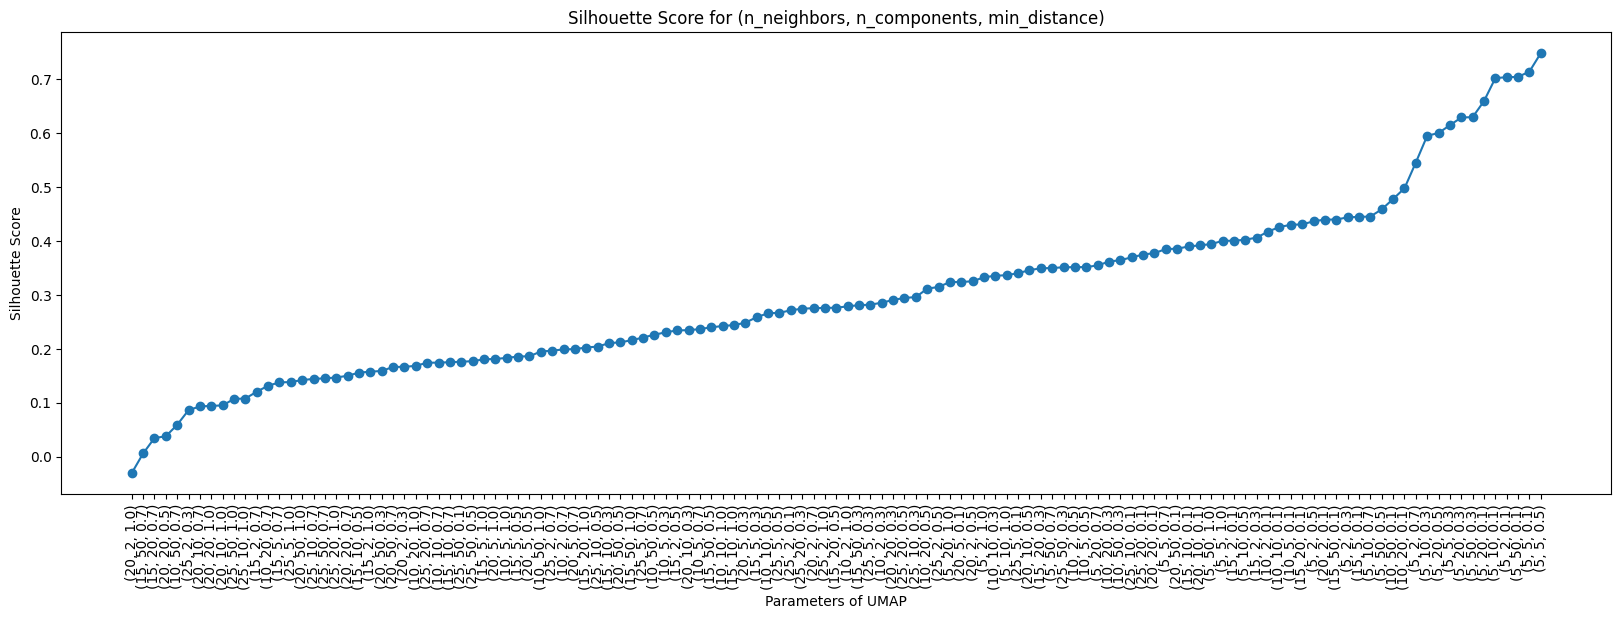

Best Parameters: (5, 5, 0.5), Silhouette Score: 0.7487215995788574


In [45]:
# Extract parameters and scores for plotting
parameters = []
for score in silhouette_scores:
    curr_params = (score['n_neighbors'], score['n_components'], score['min_distance'])
    parameters.append(curr_params)
scores = [score['silhouette_score'] for score in silhouette_scores]

# Sort parameters based on silhouette scores in ascending order
sorted_data = sorted(zip(parameters, scores), key=lambda x: x[1], reverse=False)
sorted_parameters, sorted_scores = zip(*sorted_data)

# Plotting silhouette scores
plt.figure(figsize=(20, 6))
plt.plot([str(params) for params in sorted_parameters], sorted_scores, marker='o', linestyle='-')
plt.xlabel('Parameters of UMAP')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for (n_neighbors, n_components, min_distance)')
plt.xticks(rotation=90)
plt.show()

# Find best parameters based on the highest silhouette score
best_params = sorted_parameters[-1]
best_score = sorted_scores[-1]
print(f'Best Parameters: {best_params}, Silhouette Score: {best_score}')

#### Display the image used for testing

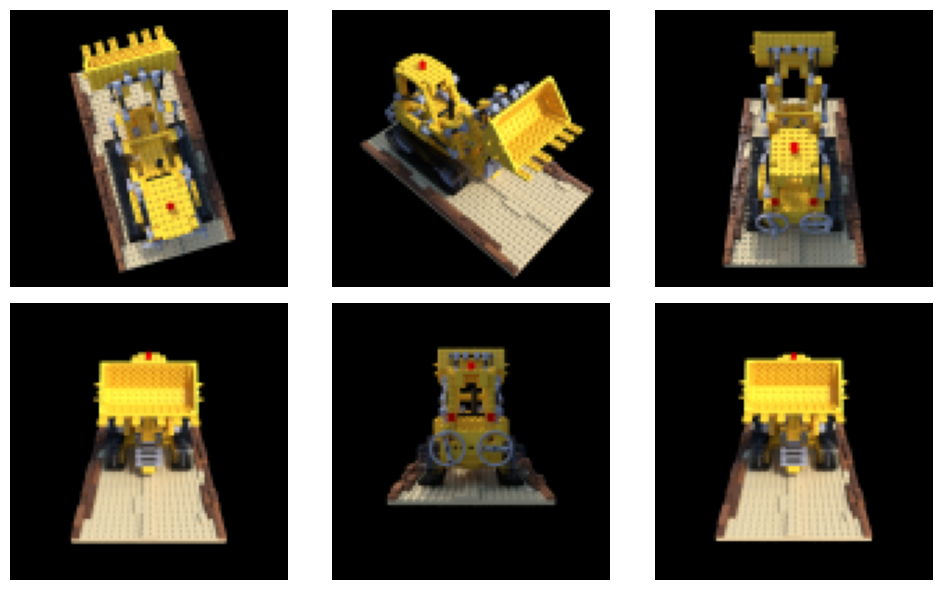

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

# Loop through all axes and images
for ax, image in zip(axs.ravel(), testimgs):
    ax.imshow(image.detach().cpu().numpy(), cmap='viridis')  # You can change the colormap if needed
    ax.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

## Train TinyNeRF!

(The cool part!)

In [17]:
# One iteration of TinyNeRF (forward pass).
def run_one_iter_of_tinynerf(height, width, focal_length, tform_cam2world,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encoding_function, get_minibatches_function):

  # Get the "bundle" of rays through all image pixels.
  ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               tform_cam2world)

  # Sample query points along each ray
  query_points, depth_values = compute_query_points_from_rays(
      ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
  )

  # "Flatten" the query points.
  flattened_query_points = query_points.reshape((-1, 3))

  # Encode the query points (default: positional encoding).
  encoded_points = encoding_function(flattened_query_points)

  # Split the encoded points into "chunks", run the model on all chunks, and
  # concatenate the results (to avoid out-of-memory issues).
  batches = get_minibatches_function(encoded_points, chunksize=chunksize)
  predictions = []
  for batch in batches:
    predictions.append(model(batch))
  radiance_field_flattened = torch.cat(predictions, dim=0)

  # "Unflatten" to obtain the radiance field.
  unflattened_shape = list(query_points.shape[:-1]) + [4]
  radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_predicted, _, _ = render_volume_density(radiance_field, ray_origins, depth_values)

  return rgb_predicted

# **Random Selection of Frames**


Frames Chosen by Random Frame Selection



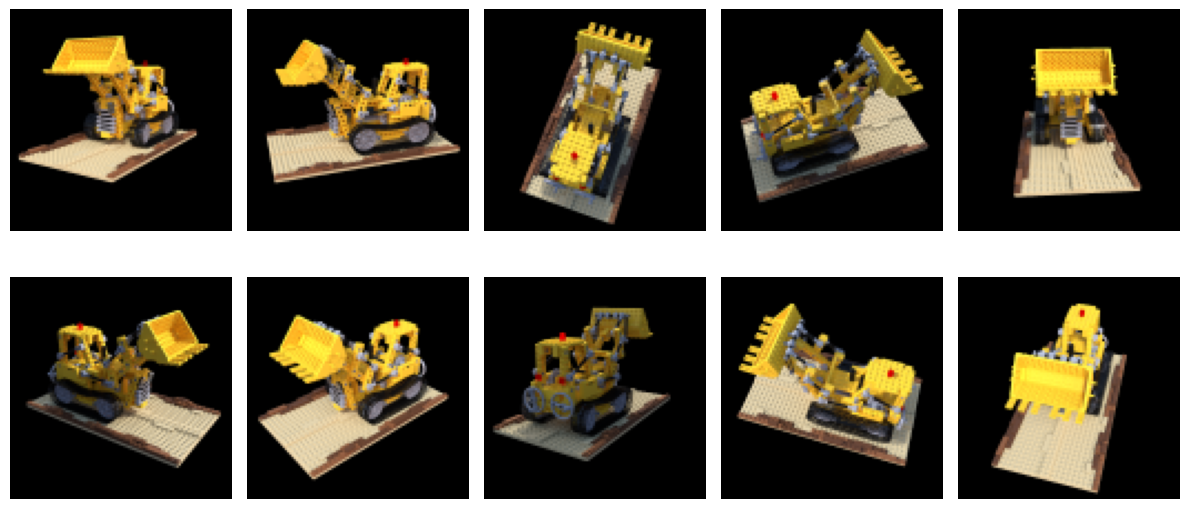

In [18]:
"""
Parameters for TinyNeRF training
"""

# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 2000

# Misc parameters
display_every = 200  # Number of iters after which stats are displayed

"""
Model
"""
model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

k = 10

# Shuffle the list of indices randomly
indices = list(range(images.shape[0]))

# Shuffle the list of indices randomly
np.random.shuffle(indices)

# Split the shuffled indices into two parts: k for training and the rest for holdout
training_indices = indices[:k]
holdout_indices = indices[k:]

# Use the indices to split the images into training and holdout arrays
training_images = images[training_indices]
holdout_images = images[holdout_indices]

# Use the indices to split the transformation matrices into training and holdout arrays
training_tforms = tform_cam2world[training_indices]
holdout_tforms = tform_cam2world[holdout_indices]

print()
print("Frames Chosen by Random Frame Selection")
print()

fig, axs = plt.subplots(2, 5, figsize=(12, 6))

# Loop through all axes and images
for ax, image in zip(axs.ravel(), training_images):
    ax.imshow(image.detach().cpu().numpy(), cmap='viridis')  # You can change the colormap if needed
    ax.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

### **Training for Random Frame Selection**

In [19]:
def calculate_lpips(img1, img2):
  # Function to calculate LPIPS
  lpips = LPIPS(net_type='alex').to(device) # The model used is Alex (lightweight)
  img1 = img1.permute(2, 0, 1).unsqueeze(0).to(device)
  img2 = img2.permute(2, 0, 1).unsqueeze(0).to(device)
  return lpips(img1, img2).item()

# Function to calculate SSIM using torchvision
def calculate_ssim(img1, img2):
    return SSIM(img1, img2, channel_axis=-1).item()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 42.5MB/s]


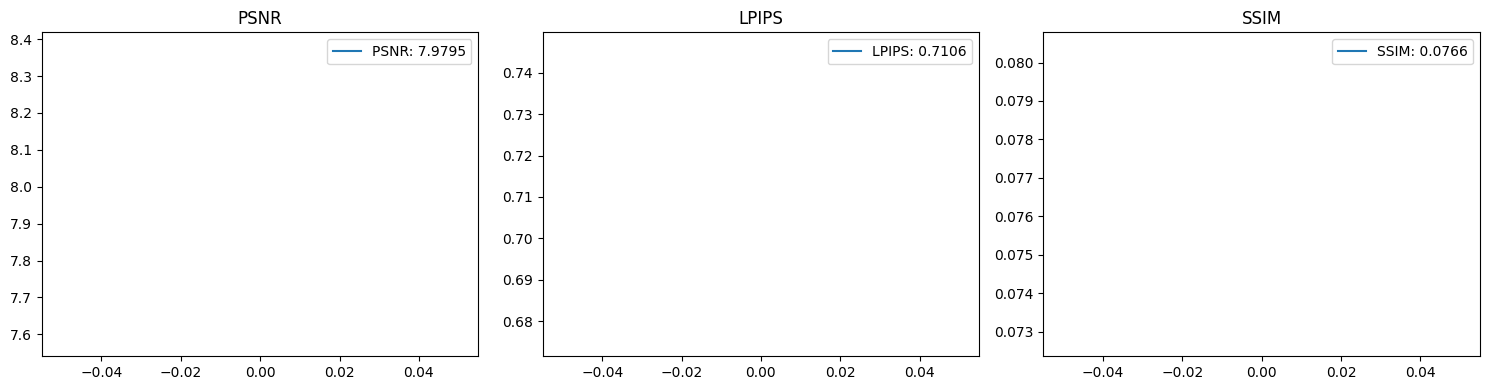

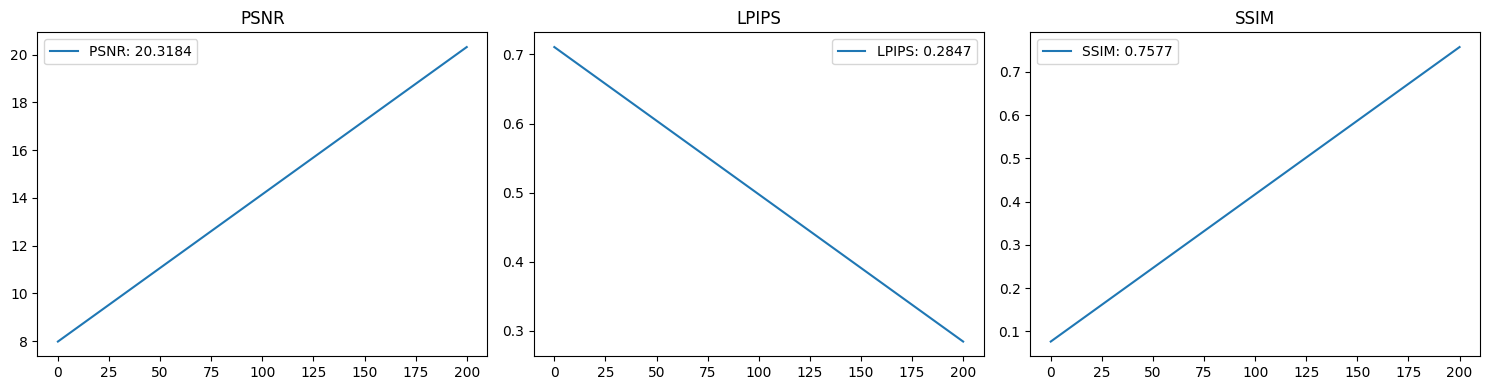

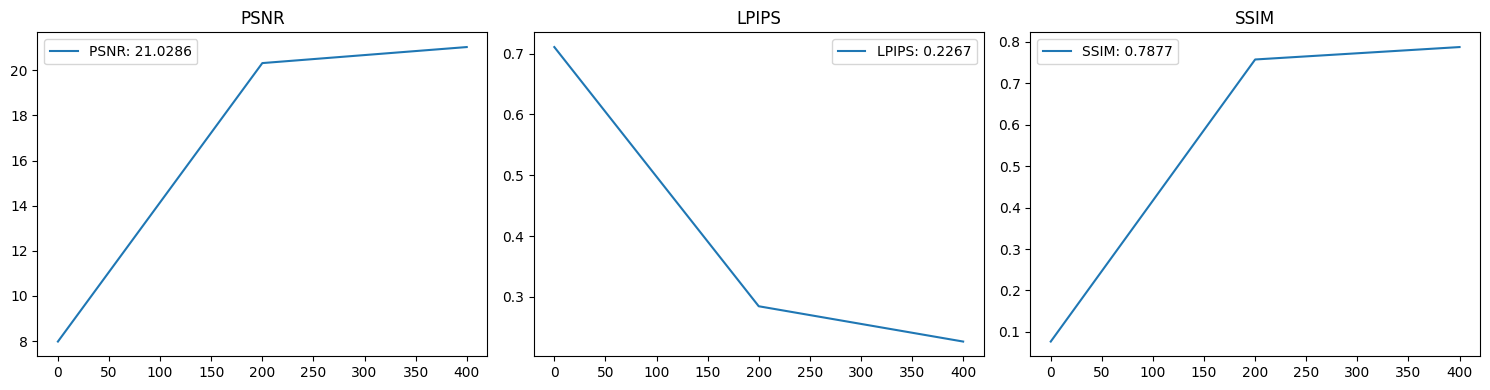

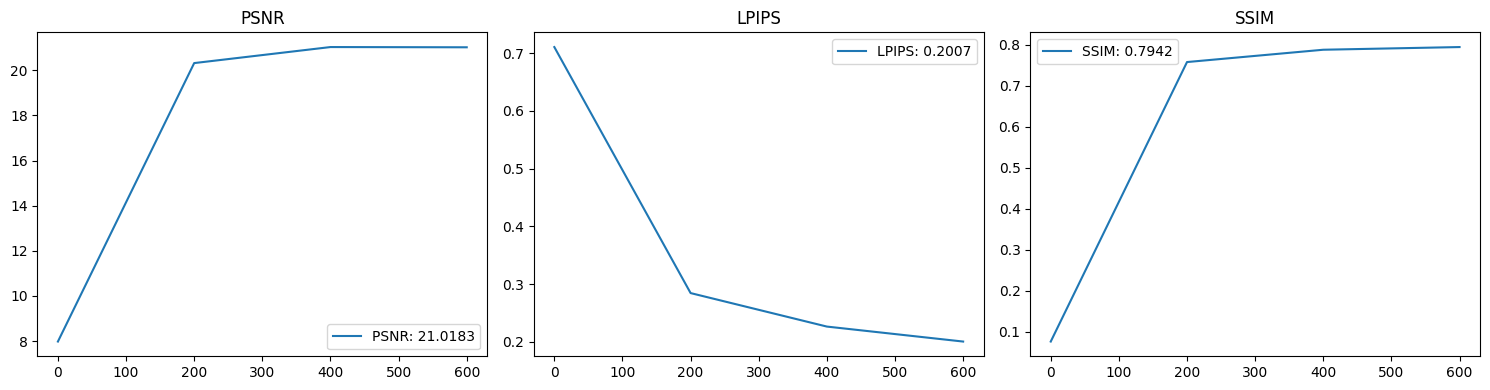

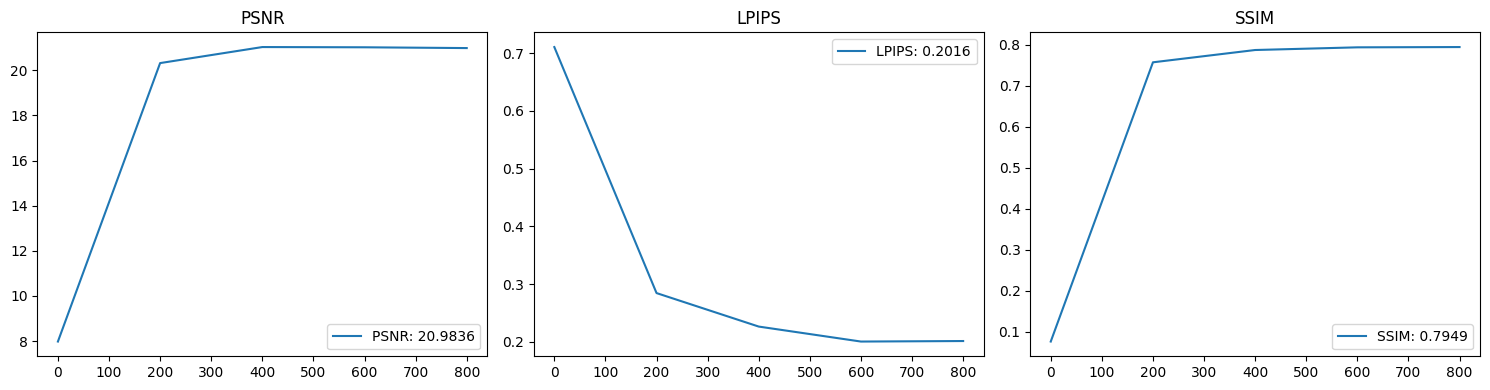

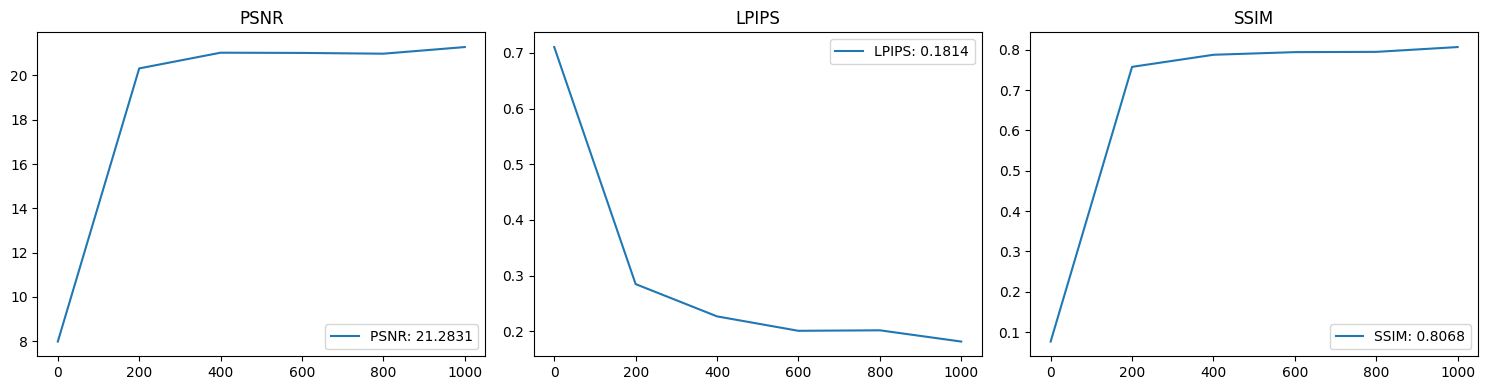

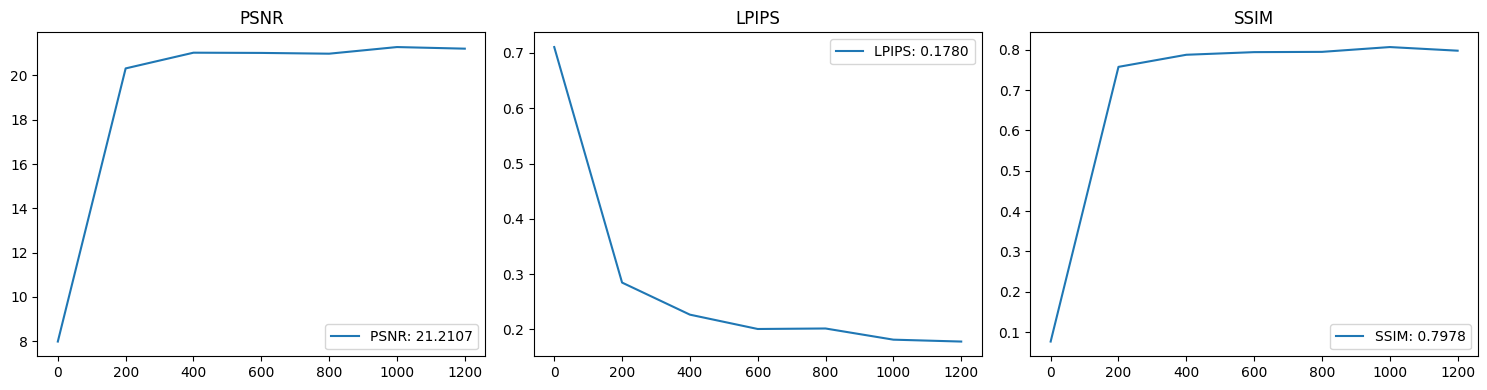

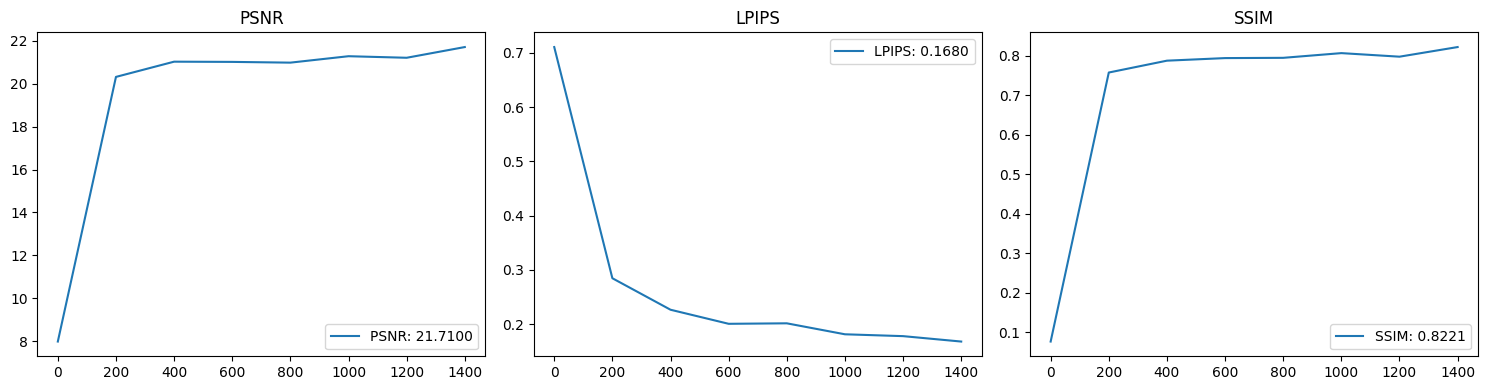

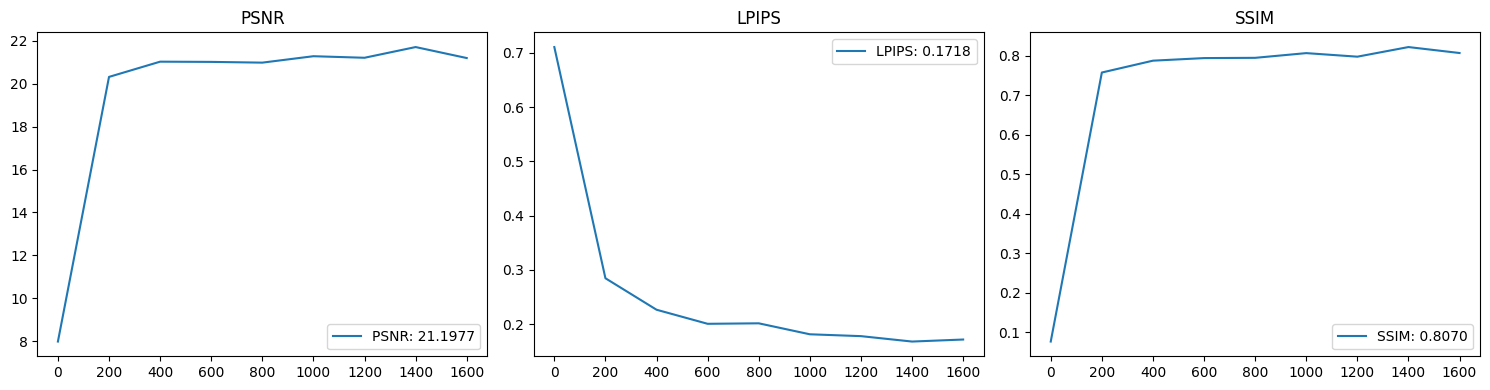

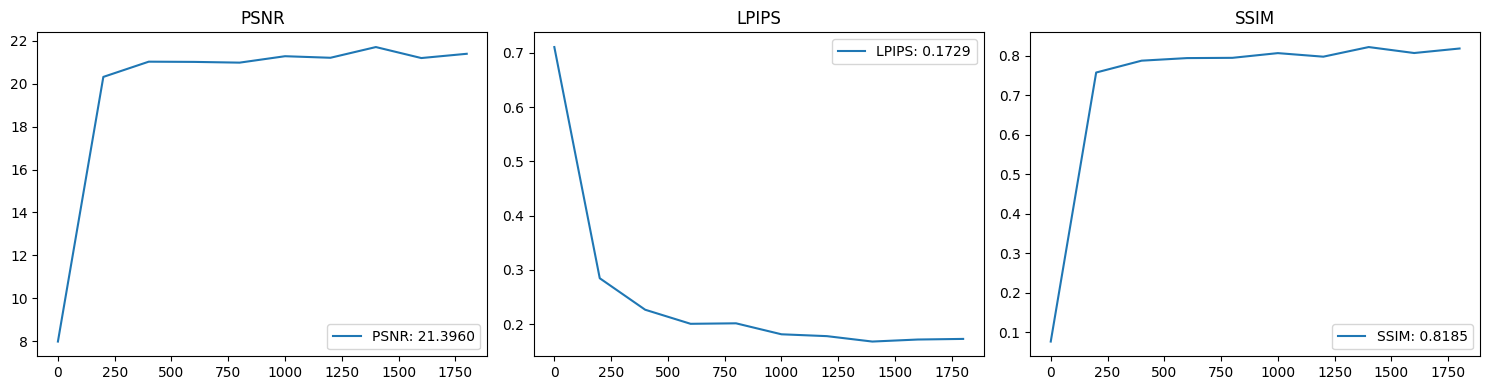

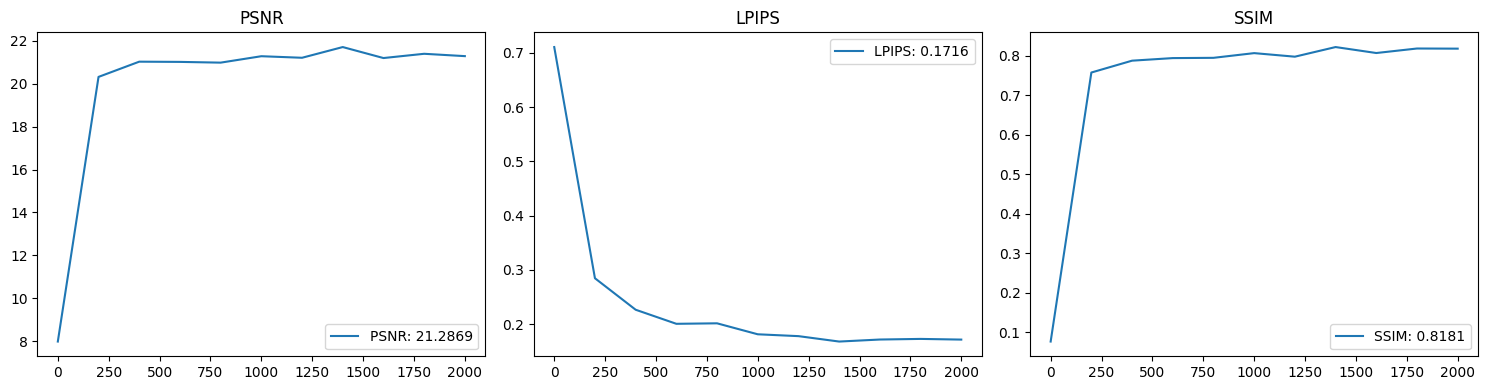

Done!


In [20]:
# Lists to log metrics etc.
psnr_vals = []
lpips_vals = []
ssim_vals = []
iternums = []

for j in range(num_iters+1):

  # Randomly pick an image as the target.
  target_img_idx = np.random.randint(training_images.shape[0])
  target_img = training_images[target_img_idx].to(device)
  target_tform_cam2world = training_tforms[target_img_idx].to(device)

  # Run one iteration of TinyNeRF and get the rendered RGB image.
  rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                          target_tform_cam2world, near_thresh,
                                          far_thresh, depth_samples_per_ray,
                                          encode, get_minibatches)

  # Compute mean-squared error between the predicted and target images. Backprop!
  loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Display images/plots/stats
  if j % display_every == 0:

    avg_psnr = []
    avg_lpips = []
    avg_ssim = []
    for testimg, testpose in zip(testimgs, testposes):
      rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                              testpose, near_thresh,
                                              far_thresh, depth_samples_per_ray,
                                              encode, get_minibatches)
      loss = torch.nn.functional.mse_loss(rgb_predicted, testimg)
      #print("Loss:", loss.item())
      psnr = -10. * torch.log10(loss)
      avg_psnr.append(psnr.item())

      lpips_loss = calculate_lpips(rgb_predicted, testimg)
      avg_lpips.append(lpips_loss)

      rgb_predicted_cpu = rgb_predicted.cpu().detach().numpy()
      testimg_cpu = testimg.cpu().detach().numpy()
      ssim_loss = calculate_ssim(rgb_predicted_cpu, testimg_cpu)
      avg_ssim.append(ssim_loss)

    psnr_vals.append(np.average(avg_psnr))
    lpips_vals.append(np.average(avg_lpips))
    ssim_vals.append(np.average(avg_ssim))

    iternums.append(j)

    # Plot PSNR, SSIM, and LPIPS in subplots
    plt.figure(figsize=(15, 4))

    plt.subplot(131)
    plt.plot(iternums, psnr_vals, label="PSNR: {:.4f}".format(psnr_vals[-1]))
    plt.legend()
    plt.title("PSNR")

    plt.subplot(132)
    plt.plot(iternums, lpips_vals, label="LPIPS: {:.4f}".format(lpips_vals[-1]))
    plt.legend()
    plt.title("LPIPS")

    plt.subplot(133)
    plt.plot(iternums, ssim_vals, label="SSIM: {:.4f}".format(ssim_vals[-1]))
    plt.legend()
    plt.title("SSIM")

    plt.tight_layout()
    plt.show()

print('Done!')

In [21]:
print("psnr:", psnr_vals[-1])
print("lpips:", lpips_vals[-1])
print("ssim:", ssim_vals[-1])

psnr: 21.286860466003418
lpips: 0.1716436135272185
ssim: 0.8181116680304209


Reconstructed Test Images


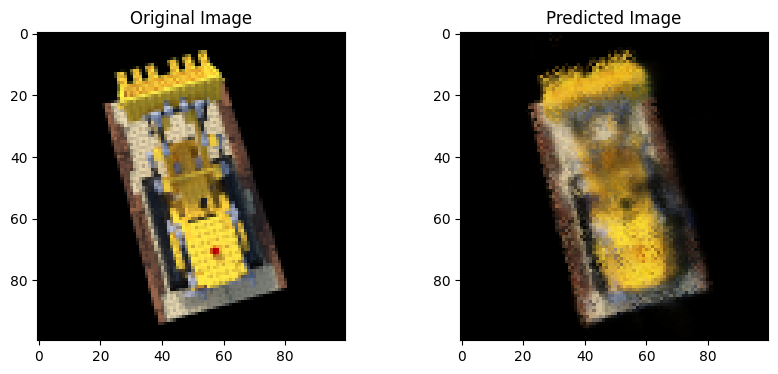

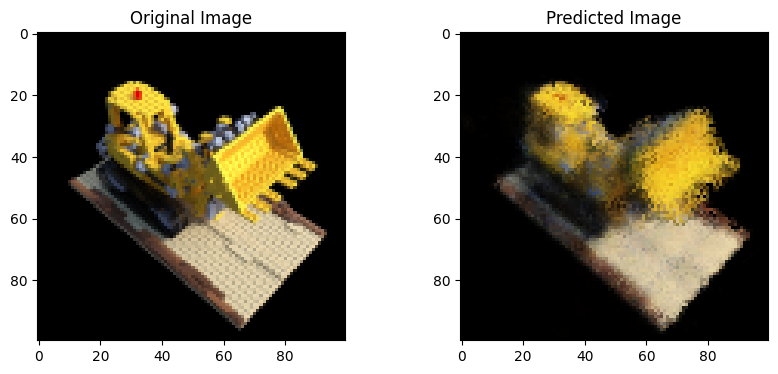

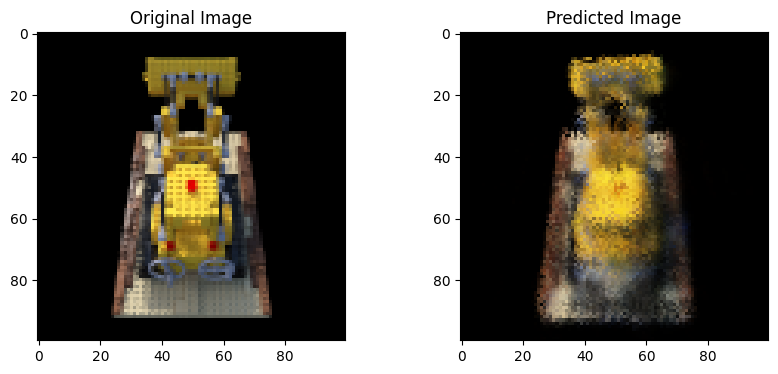

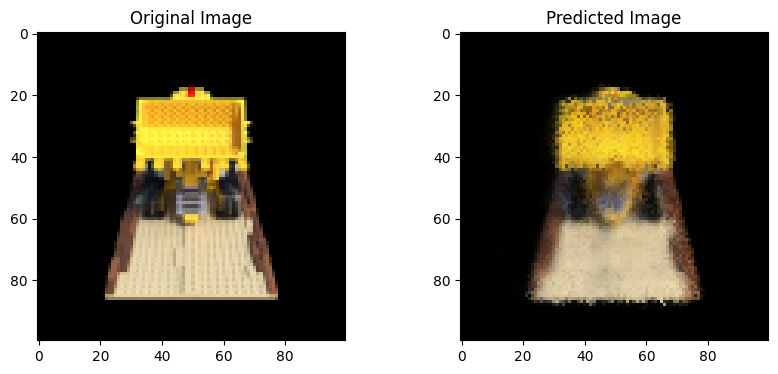

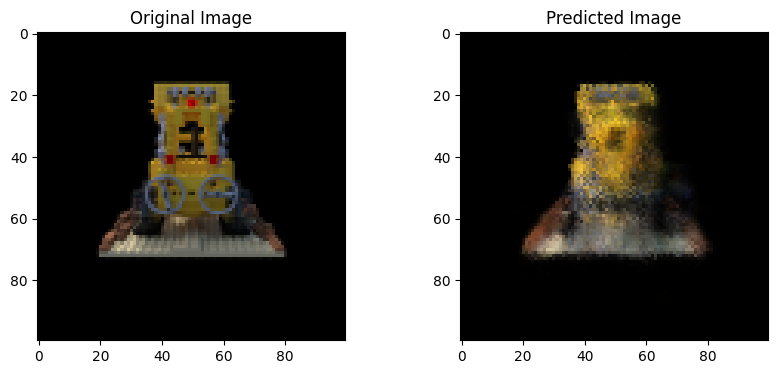

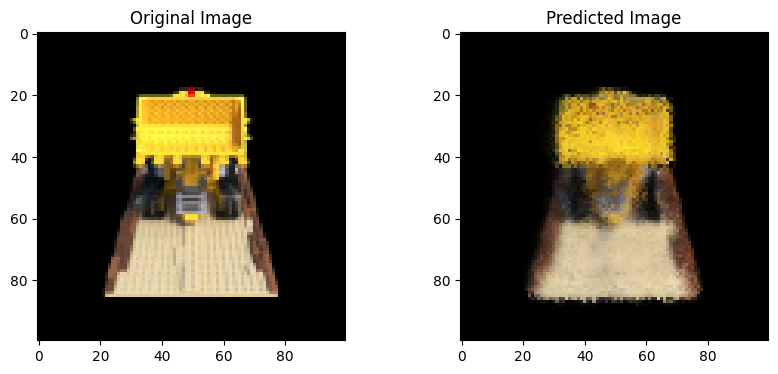

In [22]:
print("Reconstructed Test Images")
for testimg, testpose in zip(testimgs, testposes):
    rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                            testpose, near_thresh,
                                            far_thresh, depth_samples_per_ray,
                                            encode, get_minibatches)
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(testimg.detach().cpu().numpy())
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title("Predicted Image")
    #plt.axis('off')
    plt.show()

# **Furthest View Selection**

In [23]:
def camera_position_from_extrinsic_matrix(extrinsic_matrix):
    """
    Calculate the camera position from the extrinsic matrix using PyTorch.

    :param extrinsic_matrix: A 3x4 or 4x4 extrinsic matrix of the camera
    :return: The position of the camera in world coordinates
    """
    # Extract the rotation matrix (R) and the translation vector (t)
    R = extrinsic_matrix[:3, :3]
    t = extrinsic_matrix[:3, 3]

    # Calculate the camera position: C = -R^-1 * t
    camera_position = -torch.inverse(R) @ t
    return camera_position

In [24]:
def furthest_view_sampling_k(train_tform_c2w, holdout_tform_c2w, k):
    # Calculate camera positions for the training set
    training_camera_positions = [camera_position_from_extrinsic_matrix(transform) for transform in train_tform_c2w]

    # Initialize a list to hold the furthest candidates
    furthest_candidates = torch.tensor([]).to(device)

    # Calculate the distance of each candidate to all camera positions in the training set
    for holdout_transform in holdout_tform_c2w:
        holdout_position = camera_position_from_extrinsic_matrix(holdout_transform)

        # Calculate distances to all training set camera positions
        distances = torch.stack([torch.norm(holdout_position - train_pos, p=2) for train_pos in training_camera_positions])

        # Minimum distance to the training set
        min_distance = torch.min(distances)

        # Append the candidate and its minimum distance
        furthest_candidates = torch.cat((furthest_candidates, torch.unsqueeze(min_distance, 0)))

    return torch.argsort(furthest_candidates, descending=True)[:k].tolist()


Frames Chosen by Furthest View Sampling



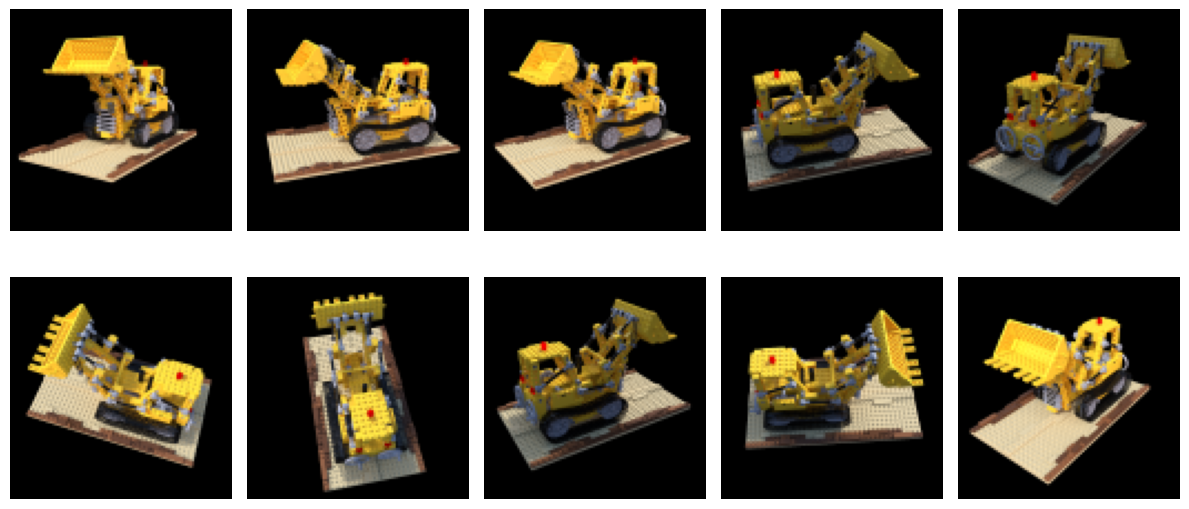

In [25]:
"""
Parameters for TinyNeRF training
"""

# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 2000

# Misc parameters
display_every = 200  # Number of iters after which stats are displayed

"""
Model
"""
model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

k = 8

# Shuffle the list of indices randomly
indices = list(range(images.shape[0]))

# Shuffle the list of indices randomly
np.random.shuffle(indices)

# Split the shuffled indices into two parts: k for training and the rest for holdout
training_indices = indices[:2]
holdout_indices = indices[2:]

# Use the indices to split the images into training and holdout arrays
training_images = images[training_indices]
holdout_images = images[holdout_indices]

# Use the indices to split the transformation matrices into training and holdout arrays
training_tforms = tform_cam2world[training_indices]
holdout_tforms = tform_cam2world[holdout_indices]

furthest_view_indices = furthest_view_sampling_k(training_tforms, holdout_tforms, k)
training_images = torch.cat((training_images, holdout_images[furthest_view_indices]))
training_tforms = torch.cat((training_tforms, holdout_tforms[furthest_view_indices]))

holdout_images = torch.stack([holdout_images[i] for i in range(holdout_images.size(0)) if i not in furthest_view_indices])
holdout_tforms = torch.stack([holdout_tforms[i] for i in range(holdout_tforms.size(0)) if i not in furthest_view_indices])

print()
print("Frames Chosen by Furthest View Sampling")
print()

fig, axs = plt.subplots(2, 5, figsize=(12, 6))

# Loop through all axes and images
for ax, image in zip(axs.ravel(), training_images):
    ax.imshow(image.detach().cpu().numpy(), cmap='viridis')  # You can change the colormap if needed
    ax.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

## **Training of Furthest View Sampling**

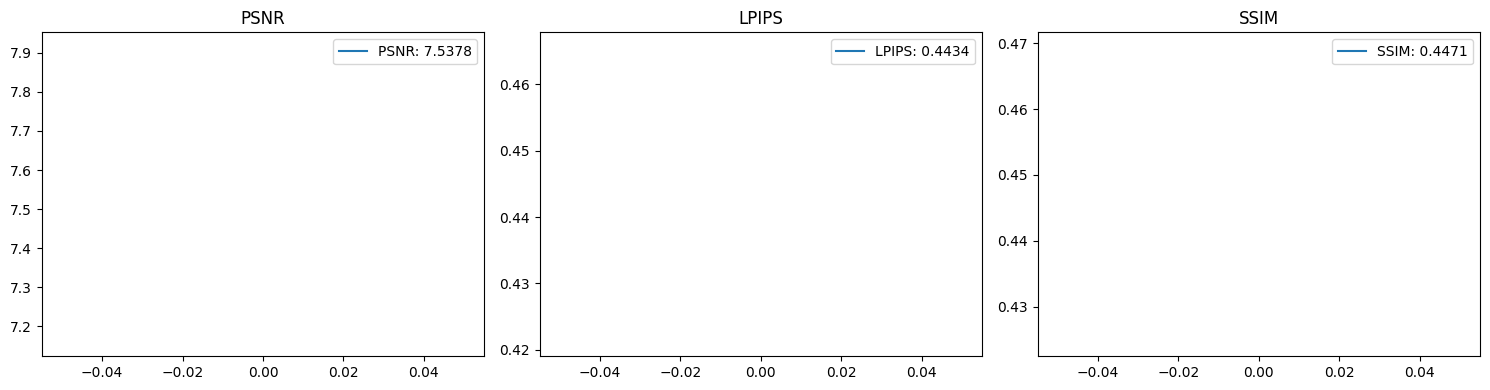

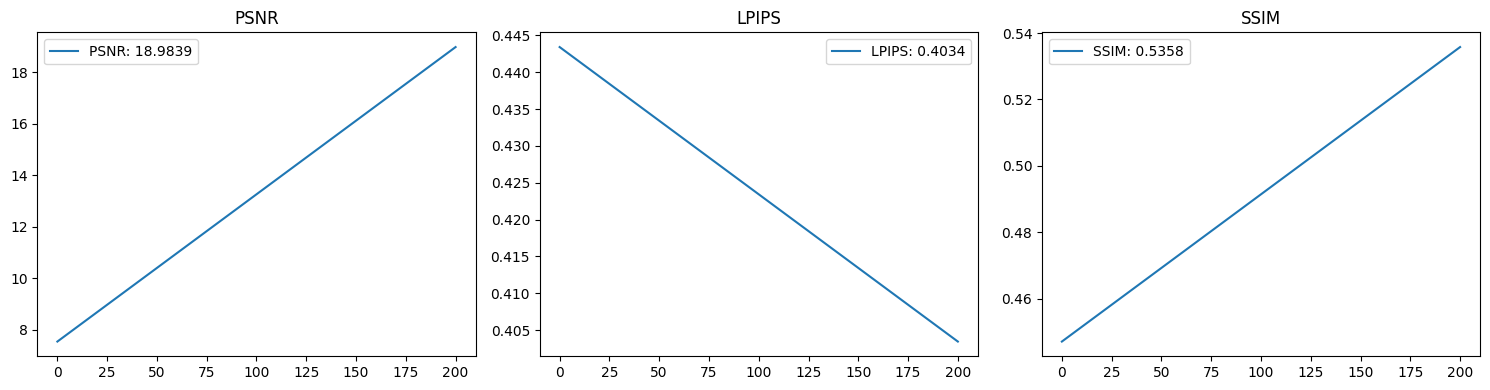

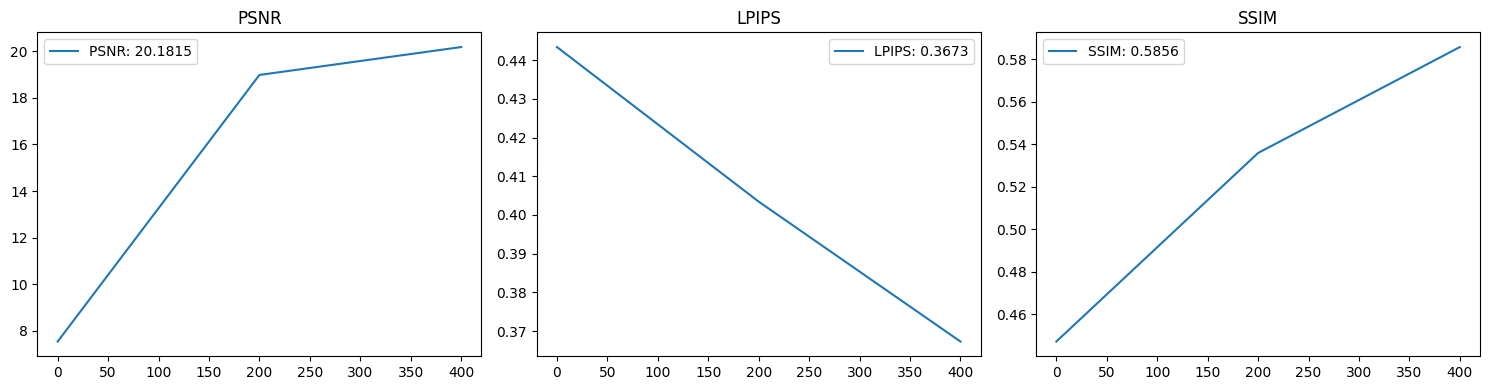

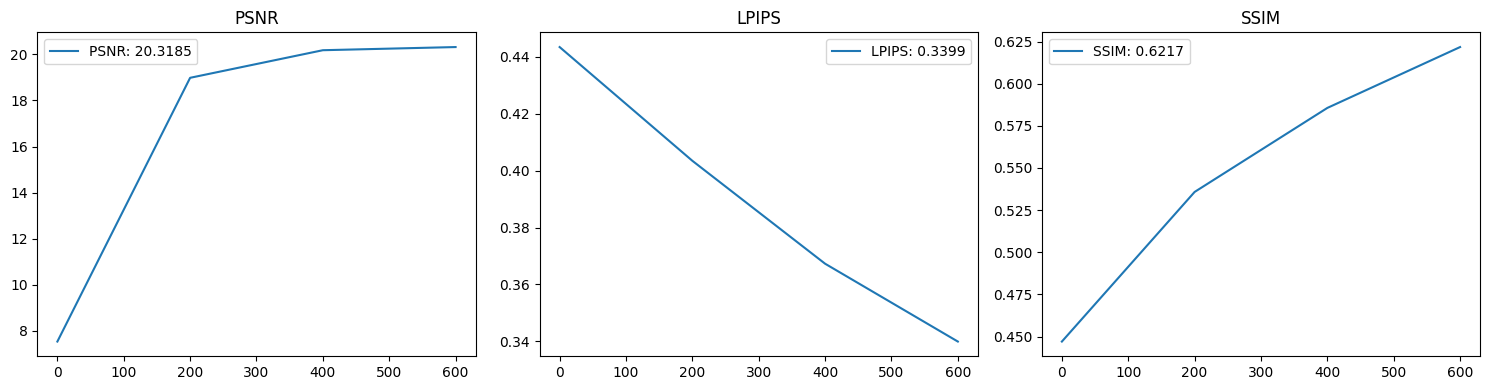

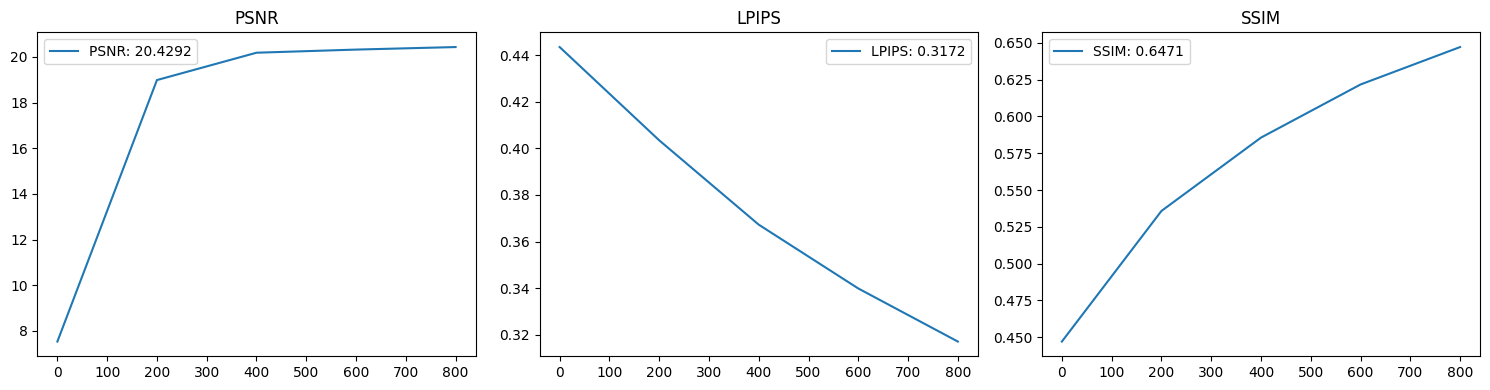

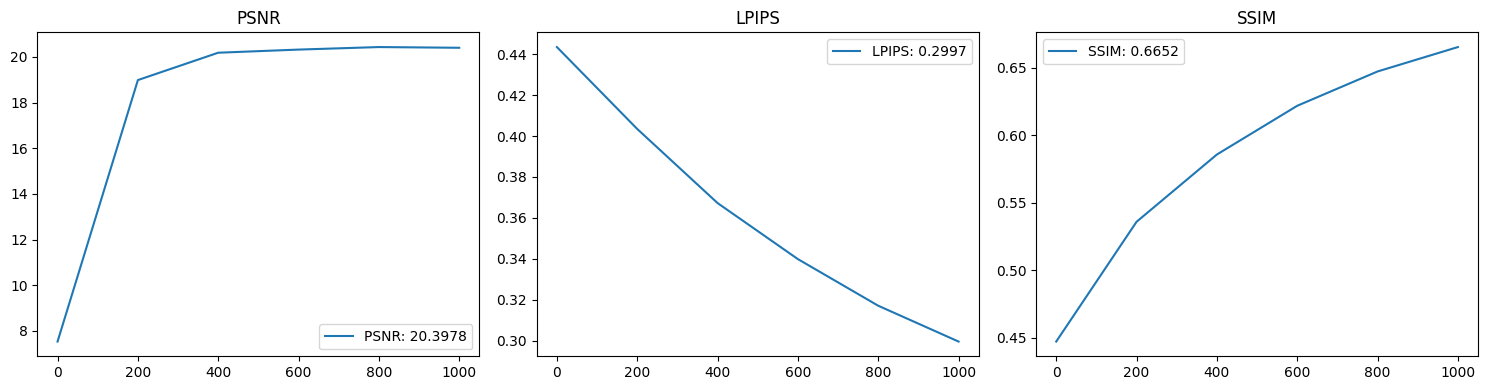

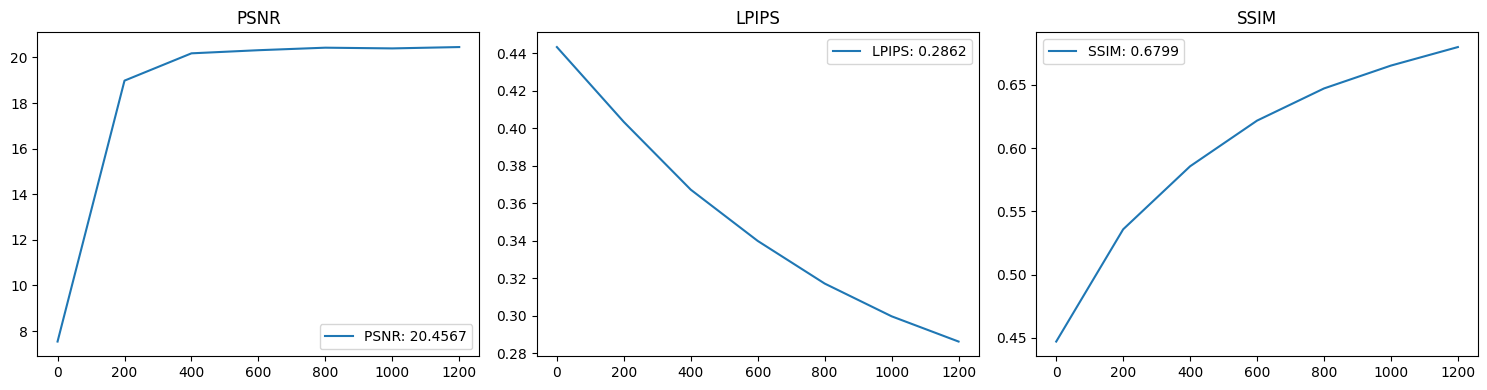

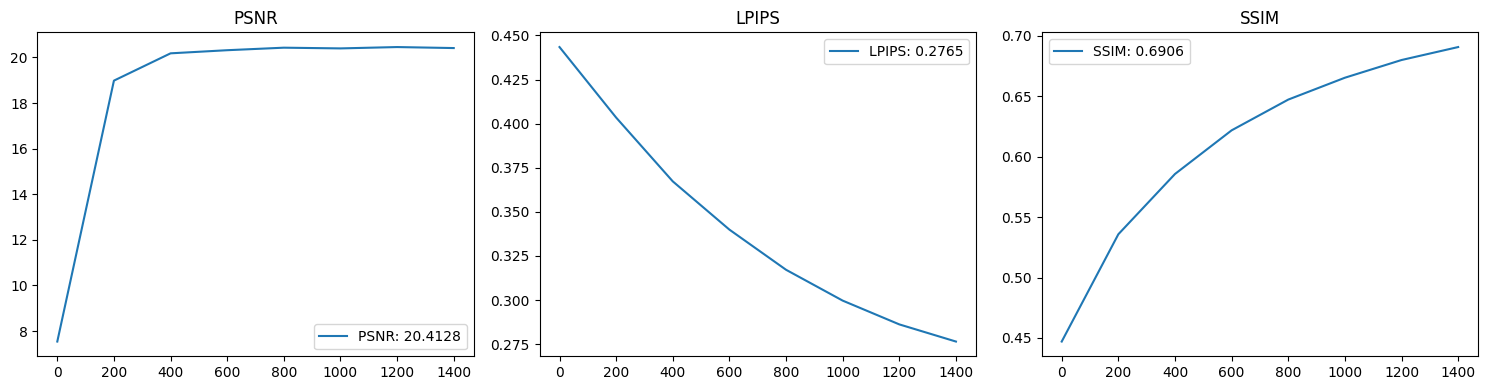

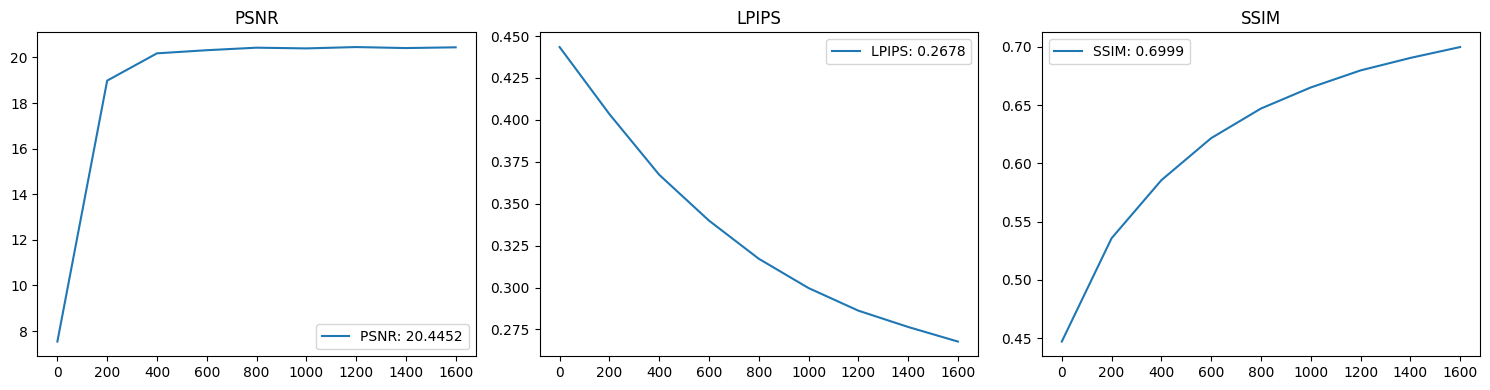

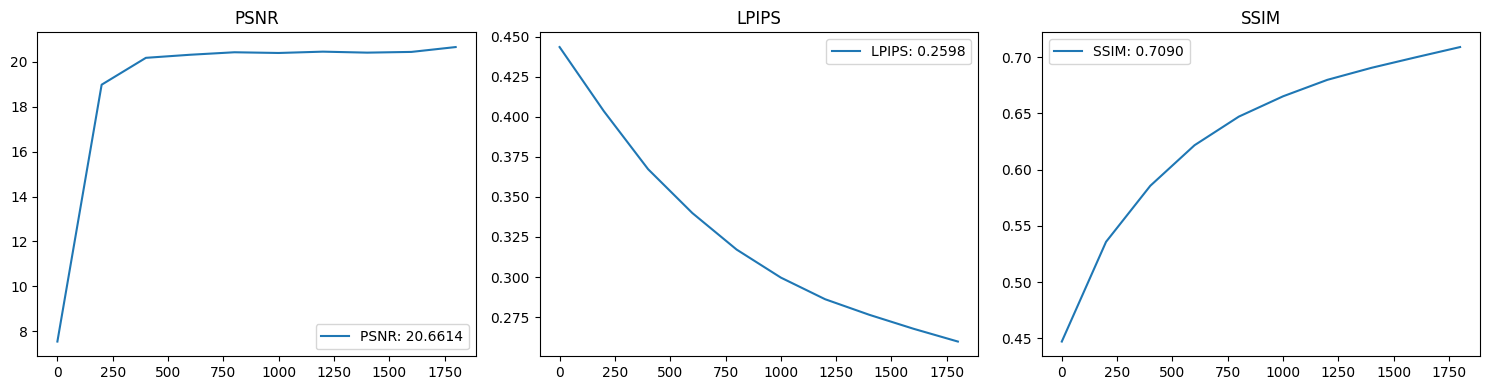

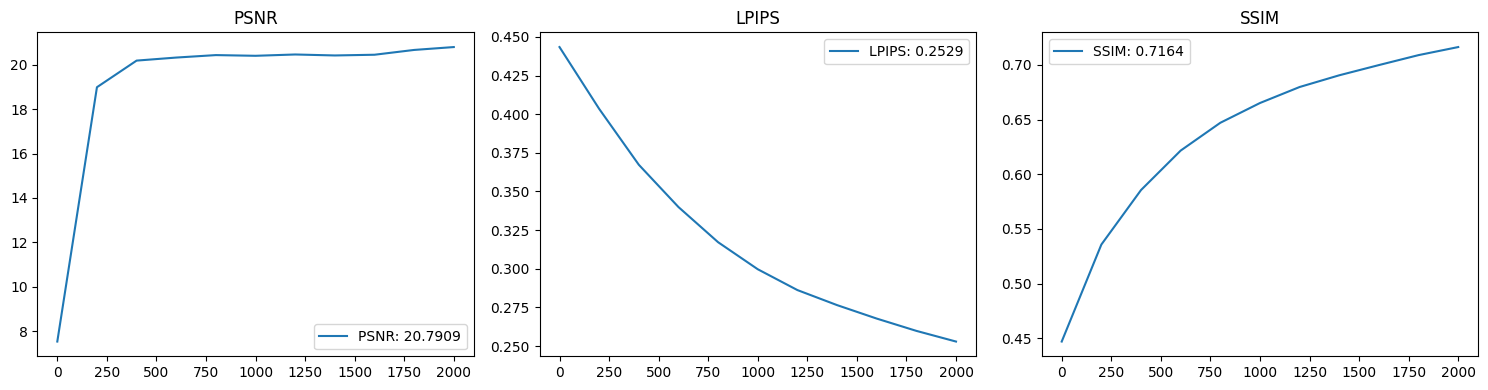

In [26]:
# List to log metric, etc.
psnr_vals = []
lpips_vals = []
ssim_vals = []
iternums = []

for j in range(num_iters+1):

  # Randomly pick an image as the target.
  target_img_idx = np.random.randint(training_images.shape[0])
  target_img = training_images[target_img_idx].to(device)
  target_tform_cam2world = training_tforms[target_img_idx].to(device)

  # Run one iteration of TinyNeRF and get the rendered RGB image.
  rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                          target_tform_cam2world, near_thresh,
                                          far_thresh, depth_samples_per_ray,
                                          encode, get_minibatches)

  # Compute mean-squared error between the predicted and target images. Backprop!
  loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Display images/plots/stats
  if j % display_every == 0:

    avg_psnr = []
    for testimg, testpose in zip(testimgs, testposes):
      rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                              testpose, near_thresh,
                                              far_thresh, depth_samples_per_ray,
                                              encode, get_minibatches)
      loss = torch.nn.functional.mse_loss(rgb_predicted, testimg)
      #print("Loss:", loss.item())
      psnr = -10. * torch.log10(loss)
      avg_psnr.append(psnr.item())

      lpips_loss = calculate_lpips(rgb_predicted, testimg)
      avg_lpips.append(lpips_loss)

      rgb_predicted_cpu = rgb_predicted.cpu().detach().numpy()
      testimg_cpu = testimg.cpu().detach().numpy()
      ssim_loss = calculate_ssim(rgb_predicted_cpu, testimg_cpu)
      avg_ssim.append(ssim_loss)

    psnr_vals.append(np.average(avg_psnr))
    lpips_vals.append(np.average(avg_lpips))
    ssim_vals.append(np.average(avg_ssim))

    iternums.append(j)

    # Plot PSNR, SSIM, and LPIPS in subplots
    plt.figure(figsize=(15, 4))

    plt.subplot(131)
    plt.plot(iternums, psnr_vals, label="PSNR: {:.4f}".format(psnr_vals[-1]))
    plt.legend()
    plt.title("PSNR")

    plt.subplot(132)
    plt.plot(iternums, lpips_vals, label="LPIPS: {:.4f}".format(lpips_vals[-1]))
    plt.legend()
    plt.title("LPIPS")

    plt.subplot(133)
    plt.plot(iternums, ssim_vals, label="SSIM: {:.4f}".format(ssim_vals[-1]))
    plt.legend()
    plt.title("SSIM")

    plt.tight_layout()
    plt.show()

In [27]:
print("psnr:", psnr_vals[-1])
print("lpips:", lpips_vals[-1])
print("ssim:", ssim_vals[-1])

psnr: 20.790931065877277
lpips: 0.25289634501354563
ssim: 0.7164003700535331


Reconstructed Test Images


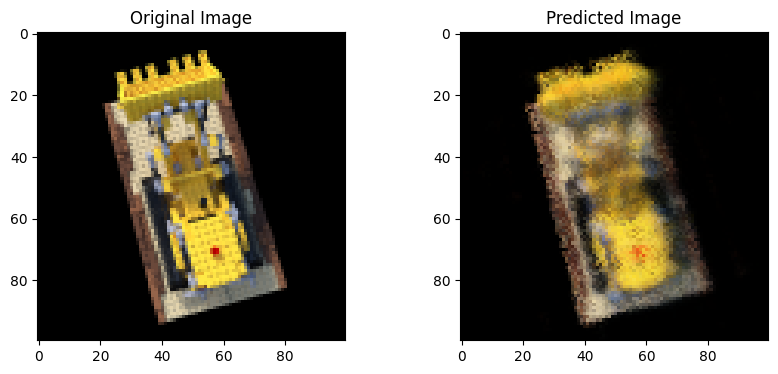

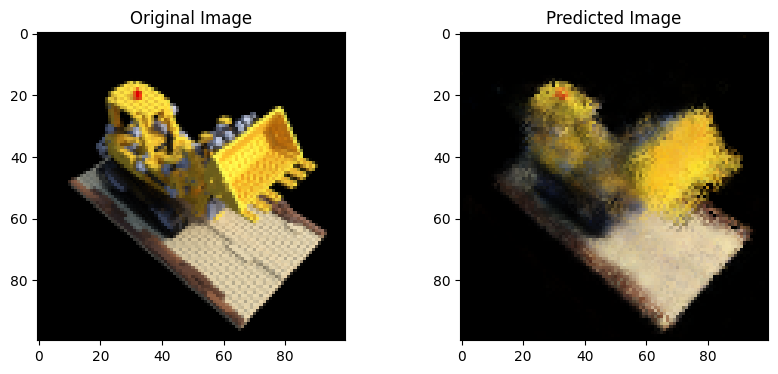

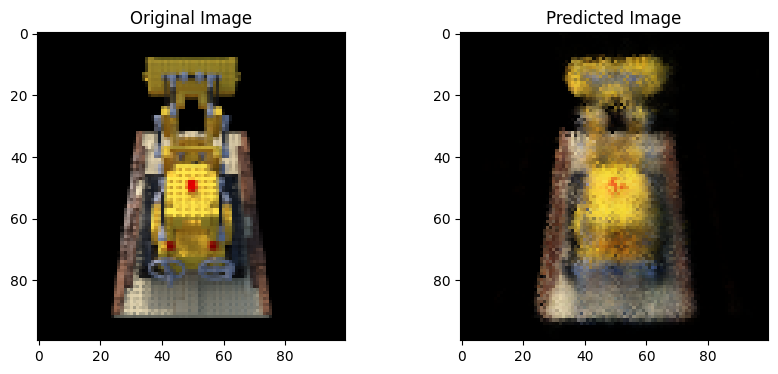

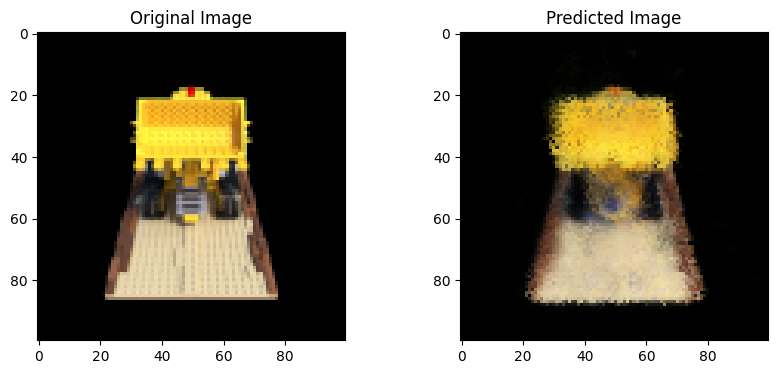

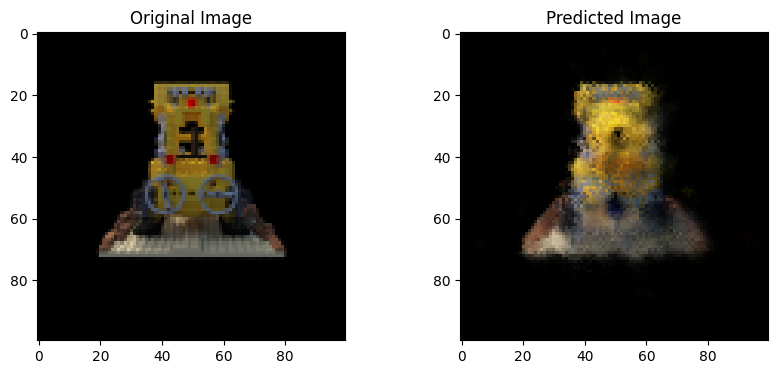

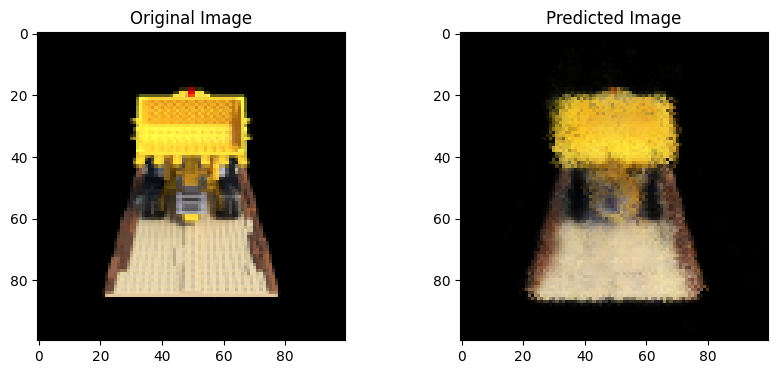

In [28]:
print("Reconstructed Test Images")
for testimg, testpose in zip(testimgs, testposes):
    rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                            testpose, near_thresh,
                                            far_thresh, depth_samples_per_ray,
                                            encode, get_minibatches)
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(testimg.detach().cpu().numpy())
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title("Predicted Image")
    #plt.axis('off')
    plt.show()

# **Image Embedding Based**

In [29]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet18(pretrained=True).to(device)
        self.resnet.eval()

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)  # Adjust the dimensions to match [channels, batch_size, height, width]
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        feats1 = self.resnet.relu(x)
        feats2 = self.resnet.layer1(self.resnet.maxpool(feats1))
        feats3 = self.resnet.layer2(feats2)
        feats4 = self.resnet.layer3(feats3)
        latents = [feats1, feats2, feats3, feats4]
        output_size = (100, 100)
        for i in range(len(latents)):
            latents[i] = F.interpolate(
                latents[i], output_size, mode="bilinear", align_corners=True
            )
        latents = torch.cat(latents, dim=1)
        return latents

In [30]:
def numpy_cosine(img1, img2):
  e1 = np.expand_dims(img1, axis=0)
  e2 = np.expand_dims(img2, axis=0)
  return 1 - cosine_similarity(e1, e2)

def extract_features(image_array):
  # Instantiate the ImageEncoder
  image_encoder = ImageEncoder()

  # Get the embeddings
  embeddings = image_encoder(image_array)

  # Perform PCA for dimensionality reduction
  #  pca = PCA(n_components=10)

  image_embd = embeddings.squeeze().contiguous().view(embeddings.size(0), -1).cpu().detach().numpy()

  pca = PCA(n_components=5)
  reduced_img_embd = pca.fit_transform(image_embd)
  scaler = StandardScaler()
  scaled_red_img_emb = scaler.fit_transform(reduced_img_embd)

  return scaled_red_img_emb

def euclidean_distance(vec1, vec2):
    return np.linalg.norm(vec1 - vec2, ord=2)

def select_diverse_images_per_cluster(embeddings, labels):
    """
    Select the most diverse image from each cluster based on cosine similarity.
    """
    unique_labels = set(labels)
    selected_indices = []

    for label in unique_labels:
        if label == -1:
            continue  # Skip noise

        cluster_indices = [i for i, lbl in enumerate(labels) if lbl == label]

        if len(cluster_indices) > 1:
            cluster_embeddings = np.array([embeddings[i] for i in cluster_indices])
            centroid = np.mean(cluster_embeddings,  axis=0)

            closest_image_index = None
            min_distance = float('inf')

            for i, embd in zip(cluster_indices, cluster_embeddings):
              # distance = euclidean_distance(embd, centroid)
              distance = numpy_cosine(embd, centroid)
              if distance < min_distance:
                  min_distance = distance
                  closest_image_index = i

            selected_indices.append(closest_image_index)

        else:
            selected_indices.append(cluster_indices[0])

    return selected_indices

In [31]:
embeddings = extract_features(images)
#labels = DBSCAN(eps=0.7, min_samples=3).fit_predict(embeddings)
labels = HDBSCAN(min_cluster_size=2, min_samples=3).fit_predict(embeddings)
diverse_indices = select_diverse_images_per_cluster(embeddings, labels)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Best Silhouette Score: 0.3346 with min_cluster_size=6 and min_samples=2
Best Davies-Bouldin Score: 1.1518 with min_cluster_size=3 and min_samples=2
Best Calinski-Harabasz Score (Herz): 27.5954 with min_cluster_size=6 and min_samples=2


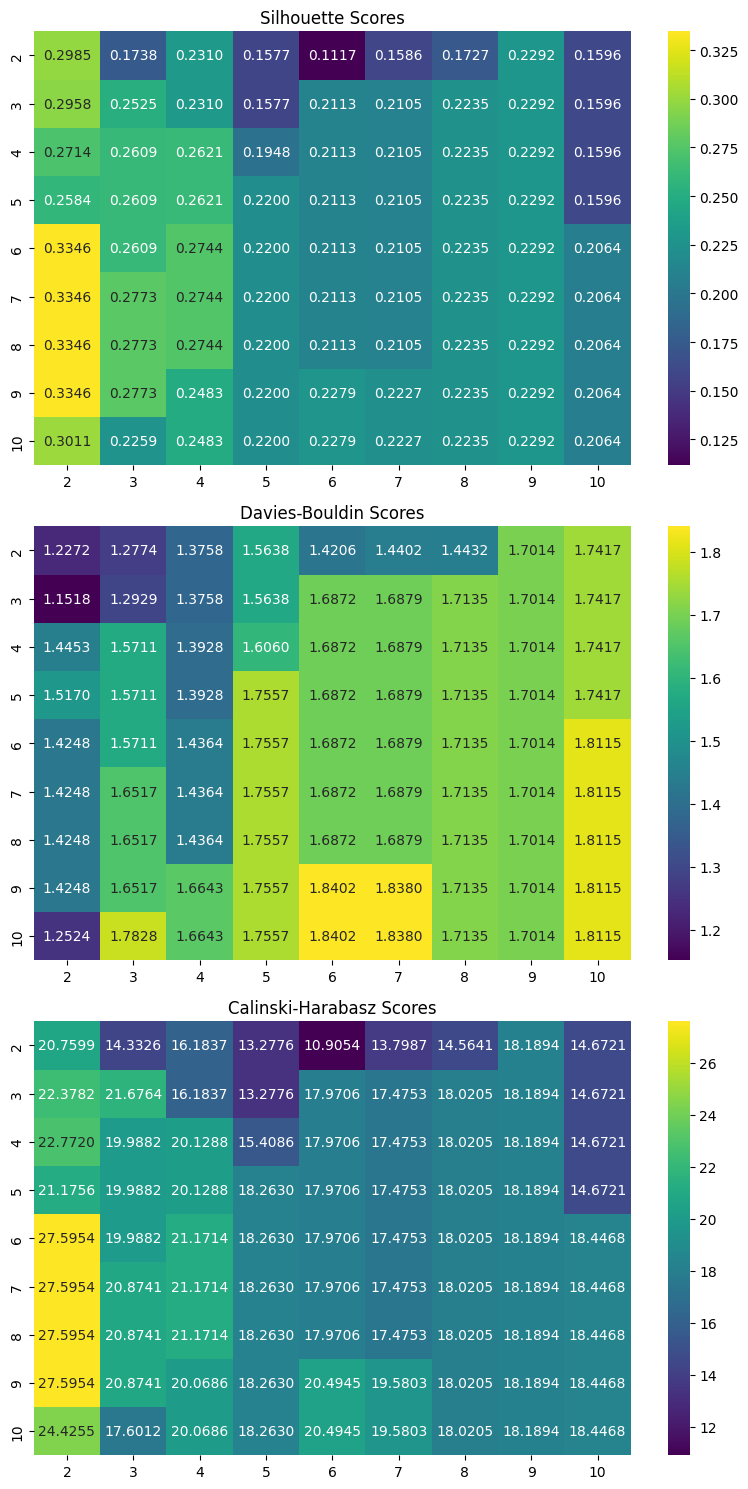

In [32]:
# Define a range of parameters to search through
min_cluster_sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Initialize arrays to store scores
silhouette_scores = np.zeros((len(min_cluster_sizes), len(min_samples_values)))
db_scores = np.zeros((len(min_cluster_sizes), len(min_samples_values)))
ch_scores = np.zeros((len(min_cluster_sizes), len(min_samples_values)))

pairs_quality = []

# Perform grid search and calculate scores
for i, min_cluster_size in enumerate(min_cluster_sizes):
    for j, min_samples in enumerate(min_samples_values):
        hdbscan = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        labels = hdbscan.fit_predict(embeddings)

        if len(np.unique(labels)) > 1:  # Ensure more than one cluster is formed
            silhouette_scores[i, j] = silhouette_score(embeddings, labels)
            db_scores[i, j] = davies_bouldin_score(embeddings, labels)
            ch_scores[i, j] = calinski_harabasz_score(embeddings, labels)

            # Append the pair and their quality scores to pairs_quality
            pairs_quality.append(((min_samples, min_cluster_size), silhouette_scores[i, j], db_scores[i, j], ch_scores[i, j]))

# Find the indices of the maximum scores
best_silhouette_indices = np.unravel_index(np.argmax(silhouette_scores), silhouette_scores.shape)
best_db_indices = np.unravel_index(np.argmin(db_scores), db_scores.shape)
best_ch_indices = np.unravel_index(np.argmax(ch_scores), ch_scores.shape)

# Print the best parameter values and scores
best_min_cluster_size_silhouette = min_cluster_sizes[best_silhouette_indices[0]]
best_min_samples_silhouette = min_samples_values[best_silhouette_indices[1]]
best_silhouette_score = silhouette_scores[best_silhouette_indices]

best_min_cluster_size_db = min_cluster_sizes[best_db_indices[0]]
best_min_samples_db = min_samples_values[best_db_indices[1]]
best_db_score = db_scores[best_db_indices]

best_min_cluster_size_ch = min_cluster_sizes[best_ch_indices[0]]
best_min_samples_ch = min_samples_values[best_ch_indices[1]]
best_ch_score = ch_scores[best_ch_indices]

print(f"Best Silhouette Score: {best_silhouette_score:.4f} with min_cluster_size={best_min_cluster_size_silhouette} and min_samples={best_min_samples_silhouette}")
print(f"Best Davies-Bouldin Score: {best_db_score:.4f} with min_cluster_size={best_min_cluster_size_db} and min_samples={best_min_samples_db}")
print(f"Best Calinski-Harabasz Score (Herz): {best_ch_score:.4f} with min_cluster_size={best_min_cluster_size_ch} and min_samples={best_min_samples_ch}")

# Visualize the scores using a heatmap
fig, ax = plt.subplots(3, 1, figsize=(8, 15))

sns.heatmap(silhouette_scores, annot=True, fmt=".4f", xticklabels=min_samples_values, yticklabels=min_cluster_sizes, ax=ax[0], cmap="viridis")
ax[0].set_title("Silhouette Scores")

sns.heatmap(db_scores, annot=True, fmt=".4f", xticklabels=min_samples_values, yticklabels=min_cluster_sizes, ax=ax[1], cmap="viridis")
ax[1].set_title("Davies-Bouldin Scores")

sns.heatmap(ch_scores, annot=True, fmt=".4f", xticklabels=min_samples_values, yticklabels=min_cluster_sizes, ax=ax[2], cmap="viridis")
ax[2].set_title("Calinski-Harabasz Scores")

plt.tight_layout()
plt.show()

In [33]:
# Assuming you have computed normalized scores for Silhouette, Davies-Bouldin, and Calinski-Harabasz (Herz)
normalized_silhouette = (silhouette_scores - np.min(silhouette_scores)) / (np.max(silhouette_scores) - np.min(silhouette_scores))
normalized_db = (db_scores - np.min(db_scores)) / (np.max(db_scores) - np.min(db_scores))
normalized_ch = (ch_scores - np.min(ch_scores)) / (np.max(ch_scores) - np.min(ch_scores))

# Calculate the combined metric
combined_metric = (normalized_silhouette + normalized_db + normalized_ch) / 3

# Find the best combined score and its corresponding parameters
best_combined_index = np.unravel_index(np.argmax(combined_metric), combined_metric.shape)
best_combined_score = np.max(combined_metric)
best_combined_params = (min_samples_values[best_combined_index[1]], min_cluster_sizes[best_combined_index[0]])

print(f"Best Combined Metric Score: {best_combined_score:.4f} with min_samples={best_combined_params[0]} and min_cluster_size={best_combined_params[1]}")

Best Combined Metric Score: 0.7989 with min_samples=2 and min_cluster_size=6


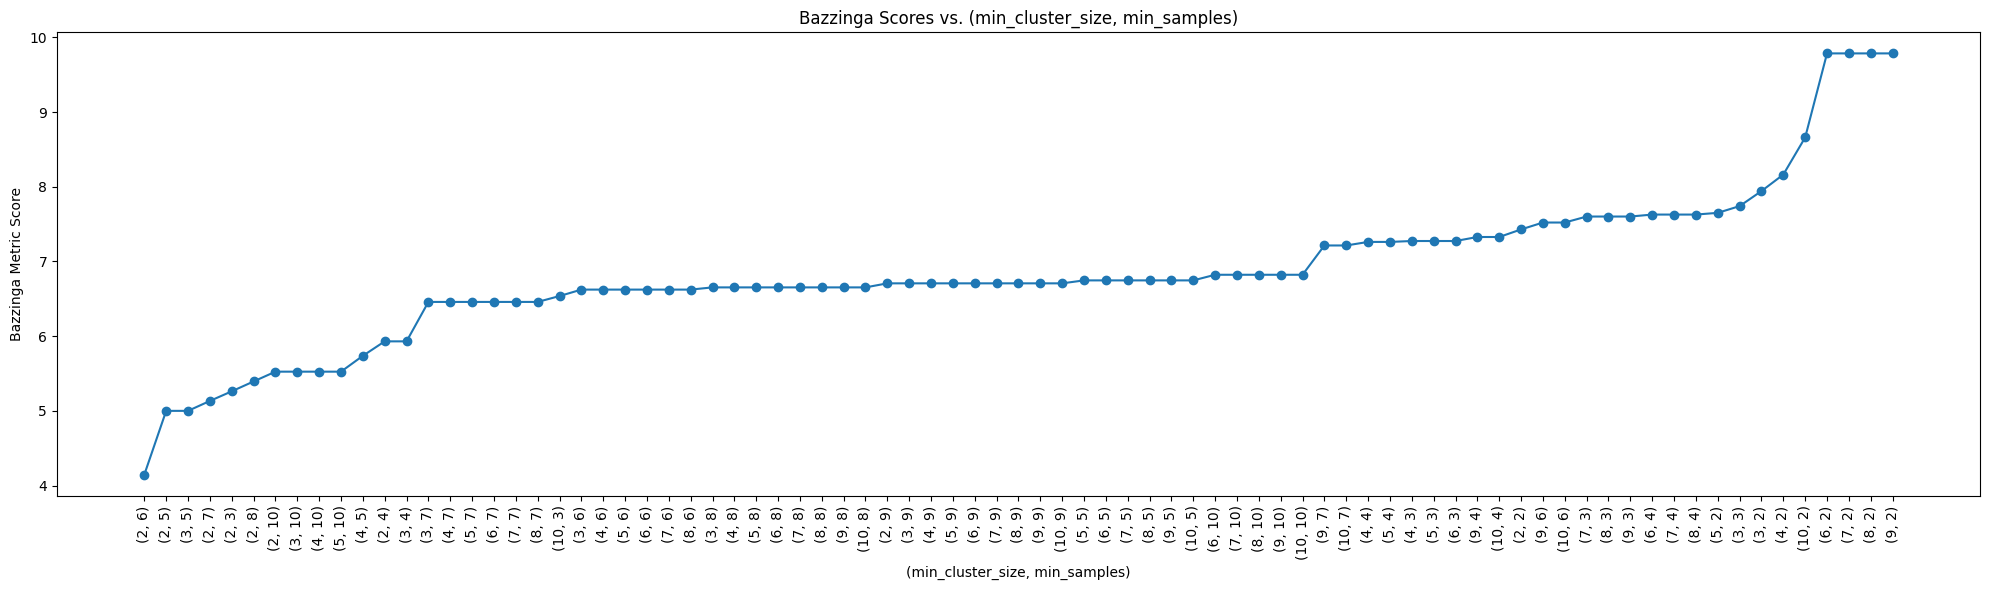

In [34]:
# Assuming you have computed the combined metric scores
# Calculate the combined metric scores (replace with your actual combined metric calculation)
combined_metric_scores = (normalized_silhouette + normalized_db + normalized_ch) / 3

# Find the best combined score and its corresponding parameters
best_combined_index = np.unravel_index(np.argmax(combined_metric_scores), combined_metric_scores.shape)
best_combined_score = np.max(combined_metric_scores)
best_combined_params = (min_samples_values[best_combined_index[1]], min_cluster_sizes[best_combined_index[0]])

# Sort pairs based on the combined metric scores in descending order
sorted_pairs_combined = sorted(pairs_quality, key=lambda x: (x[1] + x[2] + x[3]) / 3, reverse=False)

# Extract values for plotting (min_cluster_size, min_samples) vs. Combined Metric Score
sorted_samples_sizes_combined = [((pair[0][1], pair[0][0]), (pair[1] + pair[2] + pair[3]) / 3) for pair in sorted_pairs_combined]

# Find the pair corresponding to the best Combined Metric Score
best_pair_combined = sorted_pairs_combined[0][0]
best_score_combined = (sorted_pairs_combined[0][1] + sorted_pairs_combined[0][2] + sorted_pairs_combined[0][3]) / 3

# Plotting the sorted pairs based on Combined Metric Score and marking the optimal point
plt.figure(figsize=(20, 6))
plt.plot([str(pair[0]) for pair in sorted_samples_sizes_combined], [pair[1] for pair in sorted_samples_sizes_combined], marker='o')
plt.title("Bazzinga Scores vs. (min_cluster_size, min_samples)")
plt.xlabel("(min_cluster_size, min_samples)")
plt.ylabel("Bazzinga Metric Score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# **Image Embedding and H/DBSCAN**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Frames Chosen by Image Embeddings + HDBScan



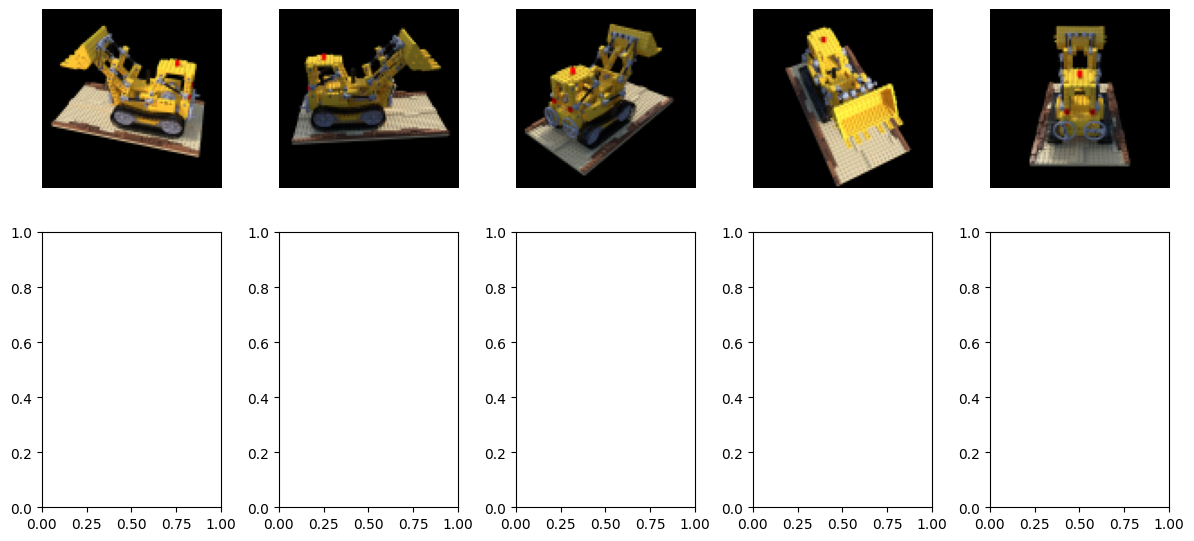

In [35]:
"""
Parameters for TinyNeRF training
"""

# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 2000

# Misc parameters
display_every = 200  # Number of iters after which stats are displayed

"""
Model
"""
model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

embeddings = extract_features(images)
#labels = DBSCAN(eps=0.7, min_samples=3).fit_predict(embeddings)
labels = HDBSCAN(min_cluster_size=6, min_samples=2).fit_predict(embeddings)
diverse_indices = select_diverse_images_per_cluster(embeddings, labels)

training_images = images[diverse_indices]
training_tforms = tform_cam2world[diverse_indices]

print()
print("Frames Chosen by Image Embeddings + HDBScan")
print()

fig, axs = plt.subplots(2, 5, figsize=(12, 6))

# Loop through all axes and images
for ax, image in zip(axs.ravel(), training_images):
    ax.imshow(image.detach().cpu().numpy(), cmap='viridis')  # You can change the colormap if needed
    ax.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

In [ ]:
np.unique(labels)
# printttt

In [ ]:
labels = HDBSCAN(min_cluster_size=9, min_samples=2).fit_predict(embeddings)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D scatter plot

# Assuming labels are the cluster labels obtained from HDBSCAN

# Create a 3D scatter plot (assuming embeddings have at least 3 dimensions)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each point with a different color based on its cluster label
for label in set(labels):
    indices = labels == label
    ax.scatter(
        embeddings[indices, 0],  # X coordinate
        embeddings[indices, 1],  # Y coordinate
        embeddings[indices, 2],  # Z coordinate
        label=f'Cluster {label}' if label != -1 else 'Noise',  # Labeling noise points
        alpha=0.8
    )

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Clusters Visualization (HDBSCAN)')
ax.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assuming labels are the cluster labels obtained from HDBSCAN
# Assuming embeddings have at least 3 dimensions

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot each point with a different color based on its cluster label
for label in set(labels):
    if label == -1:
        continue  # Skip noise points

    indices = labels == label
    cluster_points = embeddings[indices]

    # Plot cluster points
    ax.scatter(
        cluster_points[:, 0],  # X coordinate
        cluster_points[:, 1],  # Y coordinate
        cluster_points[:, 2],  # Z coordinate
        label=f'Cluster {label}',
        alpha=0.8
    )

    # Calculate centroid of the cluster
    centroid = np.mean(cluster_points, axis=0)

    # Create a sphere around the centroid to represent the cluster
    r = np.max(np.linalg.norm(cluster_points - centroid, axis=1))
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = r * np.outer(np.cos(u), np.sin(v)) + centroid[0]
    y = r * np.outer(np.sin(u), np.sin(v)) + centroid[1]
    z = r * np.outer(np.ones(np.size(u)), np.cos(v)) + centroid[2]
    ax.plot_surface(x, y, z, color='gray', alpha=0.3)

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('Clusters Visualization with Rings (HDBSCAN)')
ax.legend()
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Assuming embeddings is a numpy array of shape (n_samples, 5)
# Assuming labels are the cluster labels obtained from HDBSCAN

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot each point with a different color based on its cluster label
for label in set(labels):
    if label == -1:
        continue  # Skip noise points

    indices = labels == label
    cluster_points = embeddings[indices]

    ax.scatter(
        cluster_points[:, 0],  # Dimension 1
        cluster_points[:, 1],  # Dimension 2
        cluster_points[:, 2],  # Dimension 3
        label=f'Cluster {label}',
        alpha=0.8
    )

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('Clusters Visualization in 3D (HDBSCAN)')
ax.legend()
plt.show()


In [ ]:
# Save embeddings to a .tsv file
np.savetxt('embeddings.tsv', embeddings, delimiter='\t')

# Save labels to a .tsv file
with open('metadata.tsv', 'w') as f:
    for label in labels:
        f.write(f"{label}\n")

In [ ]:
# Lists to log metrics etc.
psnr_vals = []
lpips_vals = []
ssim_vals = []
iternums = []

for j in range(num_iters+1):

  # Randomly pick an image as the target.
  target_img_idx = np.random.randint(training_images.shape[0])
  target_img = training_images[target_img_idx].to(device)
  target_tform_cam2world = training_tforms[target_img_idx].to(device)

  # Run one iteration of TinyNeRF and get the rendered RGB image.
  rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                          target_tform_cam2world, near_thresh,
                                          far_thresh, depth_samples_per_ray,
                                          encode, get_minibatches)

  # Compute mean-squared error between the predicted and target images. Backprop!
  loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Display images/plots/stats
  if j % display_every == 0:

    avg_psnr = []
    for testimg, testpose in zip(testimgs, testposes):
      rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                              testpose, near_thresh,
                                              far_thresh, depth_samples_per_ray,
                                              encode, get_minibatches)
      loss = torch.nn.functional.mse_loss(rgb_predicted, testimg)
      #print("Loss:", loss.item())
      psnr = -10. * torch.log10(loss)
      avg_psnr.append(psnr.item())

      lpips_loss = calculate_lpips(rgb_predicted, testimg)
      avg_lpips.append(lpips_loss)

      rgb_predicted_cpu = rgb_predicted.cpu().detach().numpy()
      testimg_cpu = testimg.cpu().detach().numpy()
      ssim_loss = calculate_ssim(rgb_predicted_cpu, testimg_cpu)
      avg_ssim.append(ssim_loss)

    psnr_vals.append(np.average(avg_psnr))
    lpips_vals.append(np.average(avg_lpips))
    ssim_vals.append(np.average(avg_ssim))

    iternums.append(j)

    # Plot PSNR, SSIM, and LPIPS in subplots
    plt.figure(figsize=(15, 4))

    plt.subplot(131)
    plt.plot(iternums, psnr_vals, label="PSNR: {:.4f}".format(psnr_vals[-1]))
    plt.legend()
    plt.title("PSNR")

    plt.subplot(132)
    plt.plot(iternums, lpips_vals, label="LPIPS: {:.4f}".format(lpips_vals[-1]))
    plt.legend()
    plt.title("LPIPS")

    plt.subplot(133)
    plt.plot(iternums, ssim_vals, label="SSIM: {:.4f}".format(ssim_vals[-1]))
    plt.legend()
    plt.title("SSIM")

    plt.tight_layout()
    plt.show()

print('Done!')

In [ ]:
print("psnr:", psnr_vals[-1])
print("lpips:", lpips_vals[-1])
print("ssim:", ssim_vals[-1])

'''With cosine:

psnr: 21.66678524017334
lpips: 0.2578606837325626
ssim: 0.7238813937227759
'''

In [ ]:
print("Reconstructed Test Images")
for testimg, testpose in zip(testimgs, testposes):
    rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                            testpose, near_thresh,
                                            far_thresh, depth_samples_per_ray,
                                            encode, get_minibatches)
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(testimg.detach().cpu().numpy())
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title("Predicted Image")
    #plt.axis('off')
    plt.show()